In [312]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch


In [313]:
from sklearn.cluster import KMeans

# center and scale the data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

In [314]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# IMPORT DATA

In [315]:
cust=pd.read_excel(r'C:\Users\Deepika\Downloads\ML\CustomersData.xlsx')
cust.head(2)

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43


In [316]:
discount=pd.read_csv(r'C:\Users\Deepika\Downloads\ML\Discount_Coupon.csv')
discount.head(2)

,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20


In [317]:
spend=pd.read_csv(r'C:\Users\Deepika\Downloads\ML\Marketing_Spend.csv')
spend.head(2)

,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36


In [318]:
online_sales=pd.read_csv(r'C:\Users\Deepika\Downloads\ML\Online_Sales.csv')
online_sales.head(2)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used


In [319]:
tax_amt=pd.read_excel(r'C:\Users\Deepika\Downloads\ML\Tax_amount.xlsx')
tax_amt.head(2)

,Product_Category,GST
0,Nest-USA,0.1
1,Office,0.1


# MERGING THE DATA

In [320]:
online_sales_cust =pd.merge(online_sales, cust, on = "CustomerID", how = "left")
o_c_t =pd.merge(online_sales_cust, tax_amt, on = "Product_Category", how="left")
o_c_t.head(5)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST
0,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.10
1,17850,16680,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.10
2,17850,16681,20190101,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,M,Chicago,12,0.10
3,17850,16682,20190101,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,M,Chicago,12,0.18
4,17850,16682,20190101,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,M,Chicago,12,0.18


In [321]:
o_c_t.Transaction_Date = pd.to_datetime(o_c_t.Transaction_Date, format = "%Y%m%d")
o_c_t['tx_month'] = o_c_t.Transaction_Date.dt.strftime("%b")

In [322]:
discount.rename({'Product_Category ':'Product_Category'},axis='columns',inplace=True)

In [323]:
df =pd.merge(o_c_t, discount, left_on= ['tx_month', 'Product_Category'], right_on = ['Month', 'Product_Category' ], how = "inner")
df.head(5)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,tx_month,Month,Coupon_Code,Discount_pct
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,ELEC10,10
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,Jan,ELEC10,10
2,13047,16684,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2,122.77,6.5,Clicked,M,California,43,0.1,Jan,Jan,ELEC10,10
3,13047,16684,2019-01-01,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,1,81.50,6.5,Used,M,California,43,0.1,Jan,Jan,ELEC10,10
4,13047,16688,2019-01-01,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,122.77,6.5,Used,M,California,43,0.1,Jan,Jan,ELEC10,10


In [324]:
df.drop("tx_month", axis= 1, inplace=True)

# DATA AUDIT

In [325]:
df.shape

(52524, 17)

In [326]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52524 entries, 0 to 52523
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           52524 non-null  int64         
 1   Transaction_ID       52524 non-null  int64         
 2   Transaction_Date     52524 non-null  datetime64[ns]
 3   Product_SKU          52524 non-null  object        
 4   Product_Description  52524 non-null  object        
 5   Product_Category     52524 non-null  object        
 6   Quantity             52524 non-null  int64         
 7   Avg_Price            52524 non-null  float64       
 8   Delivery_Charges     52524 non-null  float64       
 9   Coupon_Status        52524 non-null  object        
 10  Gender               52524 non-null  object        
 11  Location             52524 non-null  object        
 12  Tenure_Months        52524 non-null  int64         
 13  GST                  52524 non-

In [327]:
df.isna().sum()

CustomerID             0
Transaction_ID         0
Transaction_Date       0
Product_SKU            0
Product_Description    0
Product_Category       0
Quantity               0
Avg_Price              0
Delivery_Charges       0
Coupon_Status          0
Gender                 0
Location               0
Tenure_Months          0
GST                    0
Month                  0
Coupon_Code            0
Discount_pct           0
dtype: int64

In [328]:
df.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status', 'Gender', 'Location',
       'Tenure_Months', 'GST', 'Month', 'Coupon_Code', 'Discount_pct'],
      dtype='object')

In [329]:
df.duplicated().sum()

0

# DATA CLEANING

In [330]:
spend['Date']=spend['Date'].apply(lambda x:pd.to_datetime(x))
spend.head(5)

,Date,Offline_Spend,Online_Spend
0,2019-01-01,4500,2424.50
1,2019-01-02,4500,3480.36
2,2019-01-03,4500,1576.38
3,2019-01-04,4500,2928.55
4,2019-01-05,4500,4055.30


In [331]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [332]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [333]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64') |(x.dtypes == 'int32') | (x.dtypes == 'float32'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

In [334]:
#define categorical list 
for x in ['Product_Category','Product_Description', 'Product_SKU','Coupon_Status',"Gender" ,"Coupon_Code"]:
    df[x]=df[x].astype('object')

In [335]:
# Separate numerical and categorical variable
# Find numerical variable in Data frame.
# This will return a list
numeric_var_names = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]

# Find Categorical variable in Data frame
cat_var_names = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object']]

#Print the data frame
print( numeric_var_names)
print(cat_var_names)

['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price', 'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct']
['Product_SKU', 'Product_Description', 'Product_Category', 'Coupon_Status', 'Gender', 'Location', 'Month', 'Coupon_Code']


In [336]:
#Convert a list in to dataframe 
#Information about numericvariable in custdata_df
df_num=df[numeric_var_names]
df_num

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct
0,17850,16679,1,153.71,6.5,12,0.10,10
1,17850,16680,1,153.71,6.5,12,0.10,10
2,13047,16684,2,122.77,6.5,43,0.10,10
3,13047,16684,1,81.50,6.5,43,0.10,10
4,13047,16688,1,122.77,6.5,43,0.10,10
...,...,...,...,...,...,...,...,...
52519,14044,47224,1,101.93,0.0,49,0.05,30
52520,15311,47511,2,25.48,0.0,40,0.05,30
52521,12842,47997,1,254.82,0.0,27,0.05,30
52522,14462,48062,1,25.48,0.0,42,0.05,30


In [337]:
#Convert a list in to dataframe 
#Information about categorical variable in custdata_df
df_cat=df[cat_var_names]
df_cat.head(5)

,Product_SKU,Product_Description,Product_Category,Coupon_Status,Gender,Location,Month,Coupon_Code
0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,ELEC10
1,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,ELEC10
2,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,Clicked,M,California,Jan,ELEC10
3,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,Used,M,California,Jan,ELEC10
4,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,Used,M,California,Jan,ELEC10


In [338]:
df_num.isna().sum()

CustomerID          0
Transaction_ID      0
Quantity            0
Avg_Price           0
Delivery_Charges    0
Tenure_Months       0
GST                 0
Discount_pct        0
dtype: int64

In [339]:
df_cat.isna().sum()

Product_SKU            0
Product_Description    0
Product_Category       0
Coupon_Status          0
Gender                 0
Location               0
Month                  0
Coupon_Code            0
dtype: int64

# DUMMY CREATION FOR CATEGORICAL VARIABLE

In [340]:
df_cat.nunique()

Product_SKU            1135
Product_Description     395
Product_Category         16
Coupon_Status             3
Gender                    2
Location                  5
Month                    12
Coupon_Code              45
dtype: int64

In [341]:
# We need to create a function for dummy creation
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname)
    col_dummies.drop(col_dummies.columns[0], axis = 1, inplace = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

In [342]:
df_cat

,Product_SKU,Product_Description,Product_Category,Coupon_Status,Gender,Location,Month,Coupon_Code
0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,ELEC10
1,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,ELEC10
2,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,Clicked,M,California,Jan,ELEC10
3,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,Used,M,California,Jan,ELEC10
4,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,Used,M,California,Jan,ELEC10
...,...,...,...,...,...,...,...,...
52519,GGOEGGCX056199,Gift Card- $100.00,Gift Cards,Clicked,M,California,Dec,GC30
52520,GGOEGGCX056299,Gift Card - $25.00,Gift Cards,Used,F,Chicago,Dec,GC30
52521,GGOEGGCX056399,Gift Card - $250.00,Gift Cards,Used,F,New Jersey,Dec,GC30
52522,GGOEGGCX056299,Gift Card - $25.00,Gift Cards,Not Used,F,Chicago,Dec,GC30


In [343]:
df_cat2 =df_cat.iloc[ :, [0,1,6,7]]
df_cat2

,Product_SKU,Product_Description,Month,Coupon_Code
0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10
1,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10
2,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10
3,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Jan,ELEC10
4,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Jan,ELEC10
...,...,...,...,...
52519,GGOEGGCX056199,Gift Card- $100.00,Dec,GC30
52520,GGOEGGCX056299,Gift Card - $25.00,Dec,GC30
52521,GGOEGGCX056399,Gift Card - $250.00,Dec,GC30
52522,GGOEGGCX056299,Gift Card - $25.00,Dec,GC30


In [344]:
df_cat1 = df_cat.iloc[ :,[2,3,4,5]]
df_cat1

,Product_Category,Coupon_Status,Gender,Location
0,Nest-USA,Used,M,Chicago
1,Nest-USA,Used,M,Chicago
2,Nest-USA,Clicked,M,California
3,Nest-USA,Used,M,California
4,Nest-USA,Used,M,California
...,...,...,...,...
52519,Gift Cards,Clicked,M,California
52520,Gift Cards,Used,F,Chicago
52521,Gift Cards,Used,F,New Jersey
52522,Gift Cards,Not Used,F,Chicago


In [345]:
cat_varlist=list(df_cat1.columns)
cat_varlist

['Product_Category', 'Coupon_Status', 'Gender', 'Location']

In [346]:
# For customer_features in categorical features

for c_feature in cat_varlist:
    df_cat1[c_feature]=df_cat1[c_feature].astype('category')
    df_cat1=create_dummies(df_cat1,c_feature)

C:\Users\Deepika\AppData\Local\Temp\ipykernel_21468\1526535554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat1[c_feature]=df_cat1[c_feature].astype('category')


In [347]:
df_cat1.sample(5)

,Product_Category_Android,Product_Category_Apparel,Product_Category_Bags,Product_Category_Bottles,Product_Category_Drinkware,Product_Category_Gift Cards,Product_Category_Headgear,Product_Category_Housewares,Product_Category_Lifestyle,Product_Category_Nest,...,Product_Category_Notebooks & Journals,Product_Category_Office,Product_Category_Waze,Coupon_Status_Not Used,Coupon_Status_Used,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC
31611,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
7972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0
3630,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
50985,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [348]:
## Merge Numerical and categorical data
df_fin = pd.concat([df_num, df_cat1,df_cat2,  df.Transaction_Date], axis=1)
df_fin.head(5)

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Product_SKU,Product_Description,Month,Coupon_Code,Transaction_Date
0,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,1,1,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01
1,17850,16680,1,153.71,6.5,12,0.1,10,0,0,...,1,1,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01
2,13047,16684,2,122.77,6.5,43,0.1,10,0,0,...,1,0,0,0,0,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10,2019-01-01
3,13047,16684,1,81.50,6.5,43,0.1,10,0,0,...,1,0,0,0,0,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Jan,ELEC10,2019-01-01
4,13047,16688,1,122.77,6.5,43,0.1,10,0,0,...,1,0,0,0,0,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Jan,ELEC10,2019-01-01


In [349]:
df_fin.shape

(52524, 35)

In [350]:
df_fin.isna().sum()

CustomerID                               0
Transaction_ID                           0
Quantity                                 0
Avg_Price                                0
Delivery_Charges                         0
Tenure_Months                            0
GST                                      0
Discount_pct                             0
Product_Category_Android                 0
Product_Category_Apparel                 0
Product_Category_Bags                    0
Product_Category_Bottles                 0
Product_Category_Drinkware               0
Product_Category_Gift Cards              0
Product_Category_Headgear                0
Product_Category_Housewares              0
Product_Category_Lifestyle               0
Product_Category_Nest                    0
Product_Category_Nest-Canada             0
Product_Category_Nest-USA                0
Product_Category_Notebooks & Journals    0
Product_Category_Office                  0
Product_Category_Waze                    0
Coupon_Stat

In [351]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52524 entries, 0 to 52523
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   CustomerID                             52524 non-null  int64         
 1   Transaction_ID                         52524 non-null  int64         
 2   Quantity                               52524 non-null  int64         
 3   Avg_Price                              52524 non-null  float64       
 4   Delivery_Charges                       52524 non-null  float64       
 5   Tenure_Months                          52524 non-null  int64         
 6   GST                                    52524 non-null  float64       
 7   Discount_pct                           52524 non-null  int64         
 8   Product_Category_Android               52524 non-null  uint8         
 9   Product_Category_Apparel               52524 non-null  uint8 

In [352]:
df_fin.duplicated().sum()

0

# EXPLOARTORY DATA ANALYSIS 

# 1.Calculating Invoice Amount/Sale Amount/Revenue

Invoice_amt=(qty * avg_price) * (1-disct_pct) * (1+gst)) + delivery_charges

In [353]:
df_fin['Revenue'] = df_fin['Quantity']*df_fin['Avg_Price']*1-df_fin['Discount_pct']*1+df_fin['GST']+df_fin.Delivery_Charges
df_fin.head(5)

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Product_SKU,Product_Description,Month,Coupon_Code,Transaction_Date,Revenue
0,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,1,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31
1,17850,16680,1,153.71,6.5,12,0.1,10,0,0,...,1,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31
2,13047,16684,2,122.77,6.5,43,0.1,10,0,0,...,0,0,0,0,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10,2019-01-01,242.14
3,13047,16684,1,81.50,6.5,43,0.1,10,0,0,...,0,0,0,0,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Jan,ELEC10,2019-01-01,78.10
4,13047,16688,1,122.77,6.5,43,0.1,10,0,0,...,0,0,0,0,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Jan,ELEC10,2019-01-01,119.37


# 2. a.Understanding how many customers acquired every month

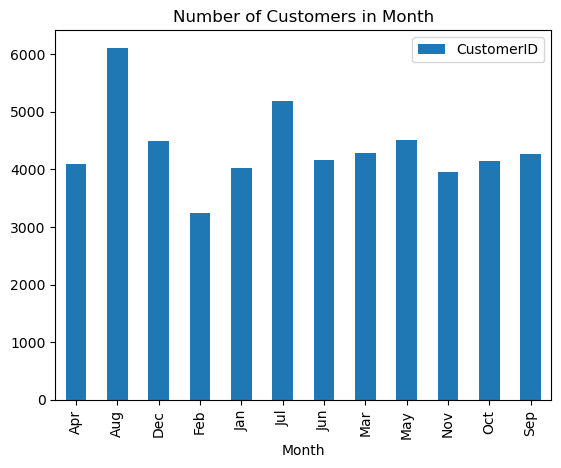

In [354]:
df_fin.groupby(by='Month')[['CustomerID']].count().plot(kind='bar',title='Number of Customers in Month')
plt.show()

# b.Understanding the retention of customers on month on month basis

In [355]:
df_fin=df_fin.assign(Occurence=np.where(~df_fin['CustomerID'].duplicated(),'New','Existing'))
df_fin.head(2)

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Location_New Jersey,Location_New York,Location_Washington DC,Product_SKU,Product_Description,Month,Coupon_Code,Transaction_Date,Revenue,Occurence
0,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,New
1,17850,16680,1,153.71,6.5,12,0.1,10,0,0,...,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Existing


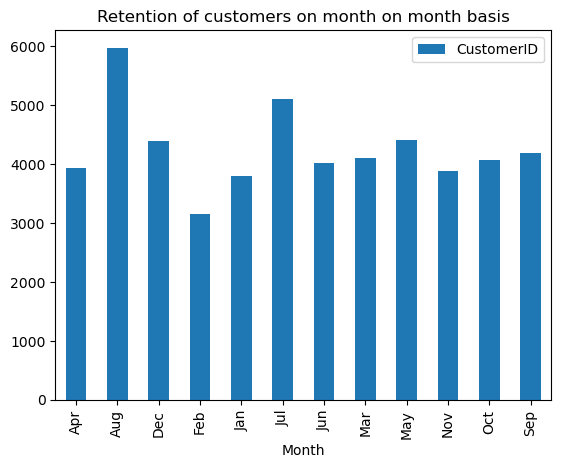

In [356]:
retention_cust=df_fin.loc[(df_fin.Occurence=='Existing')].groupby(by=['Month'])[['CustomerID']].count()
retention_cust.plot(kind='bar',title='Retention of customers on month on month basis')
plt.show()

# c.How revenue changing from new/existing customers on month on month basis

In [357]:
d=df_fin.loc[df_fin.Occurence=='New']
d.head(2)

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Location_New Jersey,Location_New York,Location_Washington DC,Product_SKU,Product_Description,Month,Coupon_Code,Transaction_Date,Revenue,Occurence
0,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,New
2,13047,16684,2,122.77,6.5,43,0.1,10,0,0,...,0,0,0,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10,2019-01-01,242.14,New


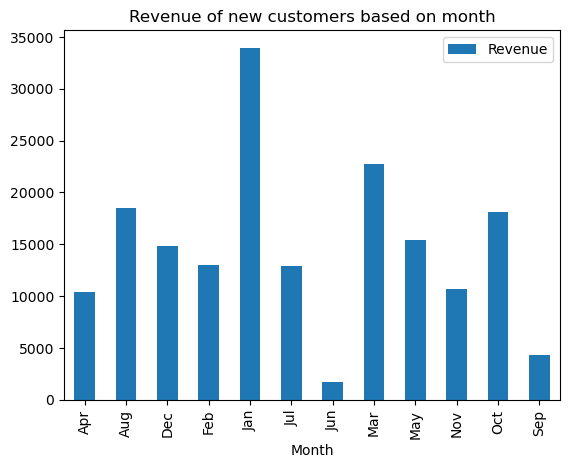

In [358]:
d.groupby(by=['Month'])[['Revenue']].sum().plot(kind='bar',title='Revenue of new customers based on month')
plt.show()


In [359]:
d1=df_fin.loc[df_fin.Occurence=='Existing']
d1.head(2)

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Location_New Jersey,Location_New York,Location_Washington DC,Product_SKU,Product_Description,Month,Coupon_Code,Transaction_Date,Revenue,Occurence
1,17850,16680,1,153.71,6.5,12,0.1,10,0,0,...,0,0,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Existing
3,13047,16684,1,81.50,6.5,43,0.1,10,0,0,...,0,0,0,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Jan,ELEC10,2019-01-01,78.10,Existing


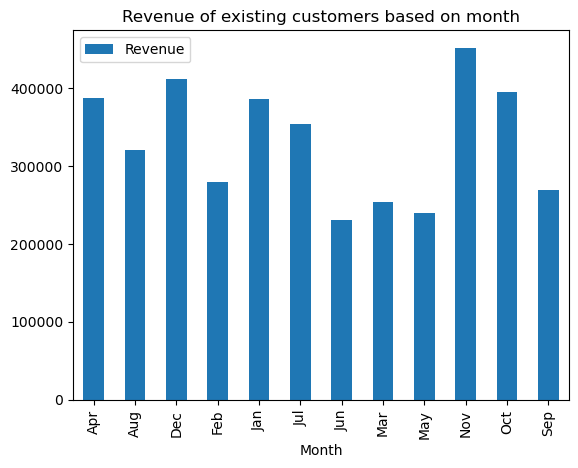

In [360]:
d1.groupby(by=['Month'])[['Revenue']].sum().plot(kind='bar',title='Revenue of existing customers based on month')
plt.show()

# d.How discount is playing the role in revenue

In [361]:
df_fin.groupby(by=['Discount_pct'])[['Revenue']].sum()

,Revenue
Discount_pct,
10,1596381.16
20,1348257.38
30,1208475.35


# e. Analyzing KPI's like Revenue,number of orders,average order value,numbers of customers(new/existing), quantity by category,month,day,week etc..                                                                                                                                                                                                                                                               f. Understanding the trends/seasonality of sales by month,location,category etc..

In [362]:
df_fin.Revenue.sum()

4153113.8899999997

In [363]:
df_fin.Quantity.sum() #number of orders

236367

In [364]:
df1=df_fin.iloc[:,[0,1,17]]
df1.head(5)

,CustomerID,Transaction_ID,Product_Category_Nest
0,17850,16679,0
1,17850,16680,0
2,13047,16684,0
3,13047,16684,0
4,13047,16688,0


In [365]:
df1=df.groupby(by=['CustomerID'])[['Transaction_ID']].count()  #finding number of transaction per customer
df1

,Transaction_ID
CustomerID,
12346,2
12347,59
12348,23
12350,17
12356,36
...,...
18259,6
18260,39
18269,8


In [366]:
df1['Avg_order_value']=df_fin['Revenue']/df1['Transaction_ID']  #finding avg_order_value
df1

,Transaction_ID,Avg_order_value
CustomerID,,
12346,2,2.735000
12347,59,0.540000
12348,23,0.342174
12350,17,0.698235
12356,36,0.374167
...,...,...
18259,6,-0.088333
18260,39,0.137692
18269,8,0.396250


In [367]:
new_cust=df_fin.loc[df_fin.Occurence=='New']
new_cust.Occurence.count()

1468

In [368]:
ex_cust=df_fin.loc[df_fin.Occurence=='Existing']
ex_cust.Occurence.count()

51056

In [369]:
df.groupby(by='Product_Category')[['Quantity']].sum().sort_values(by='Quantity',ascending=False)

,Quantity
Product_Category,
Office,88383
Apparel,32438
Drinkware,30501
Lifestyle,24881
Nest-USA,21430
Bags,15273
Notebooks & Journals,9556
Headgear,3533
Nest,2837


In [370]:
df_fin['Day']=df_fin.Transaction_Date.apply(lambda x:x.day)
df_fin['Week']=df_fin.Transaction_Date.apply(lambda x:x.week)
df_fin.head(2)

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Location_Washington DC,Product_SKU,Product_Description,Month,Coupon_Code,Transaction_Date,Revenue,Occurence,Day,Week
0,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,New,1,1
1,17850,16680,1,153.71,6.5,12,0.1,10,0,0,...,0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Existing,1,1


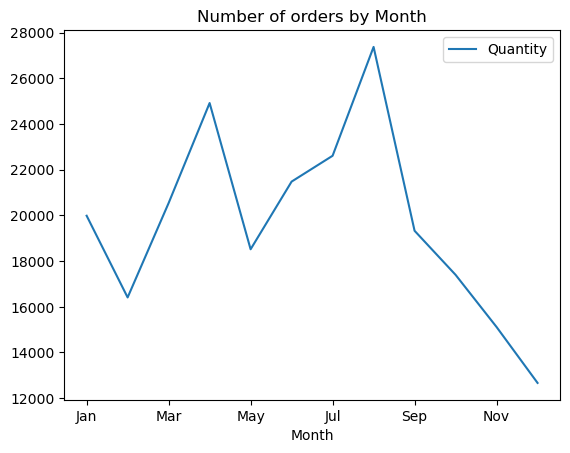

In [371]:
df2=df_fin.groupby(by='Month')[['Quantity']].sum().reset_index()
df2.sort_index()
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df2.index = pd.CategoricalIndex(df2['Month'], categories= sort_order, ordered  = True)
df2 =df2.sort_index()
df2.plot(x='Month', y= 'Quantity', kind ="line",title='Number of orders by Month')
plt.show()


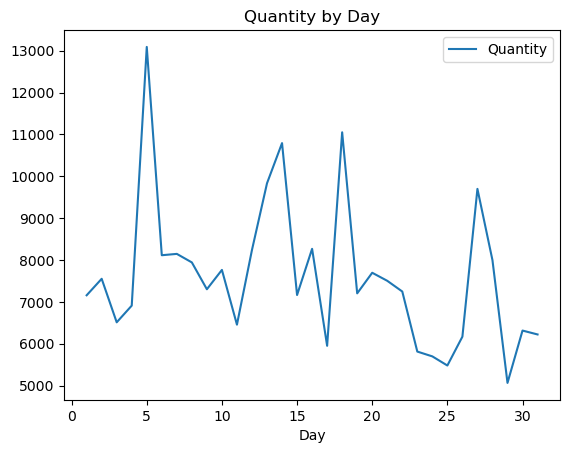

In [372]:
df_fin.groupby(by='Day')[['Quantity']].sum().plot(kind='line',title='Quantity by Day')
plt.show()

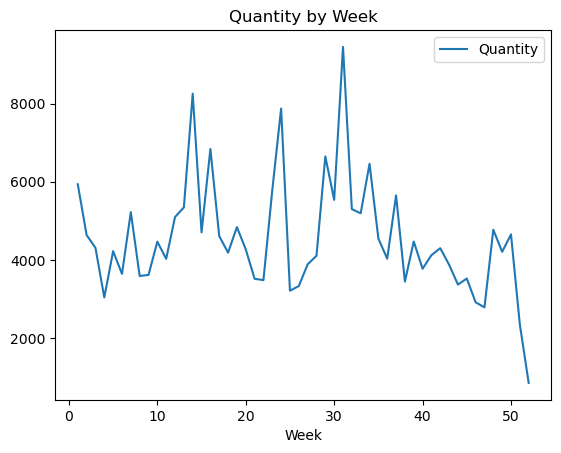

In [373]:
df_fin.groupby(by='Week')[['Quantity']].sum().plot(kind='line',title='Quantity by Week')
plt.show()

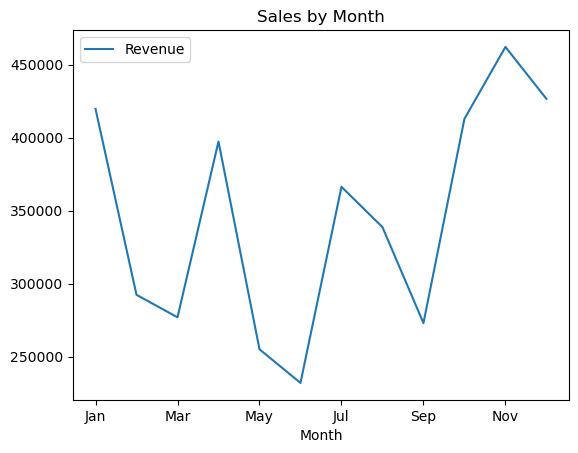

In [374]:
df2=df_fin.groupby(by='Month')[['Revenue']].sum().reset_index()
df2.sort_index()
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df2.index = pd.CategoricalIndex(df2['Month'], categories= sort_order, ordered  = True)
df2 =df2.sort_index()
df2.plot(x='Month', y= 'Revenue', kind ="line",title='Sales by Month')
plt.show()

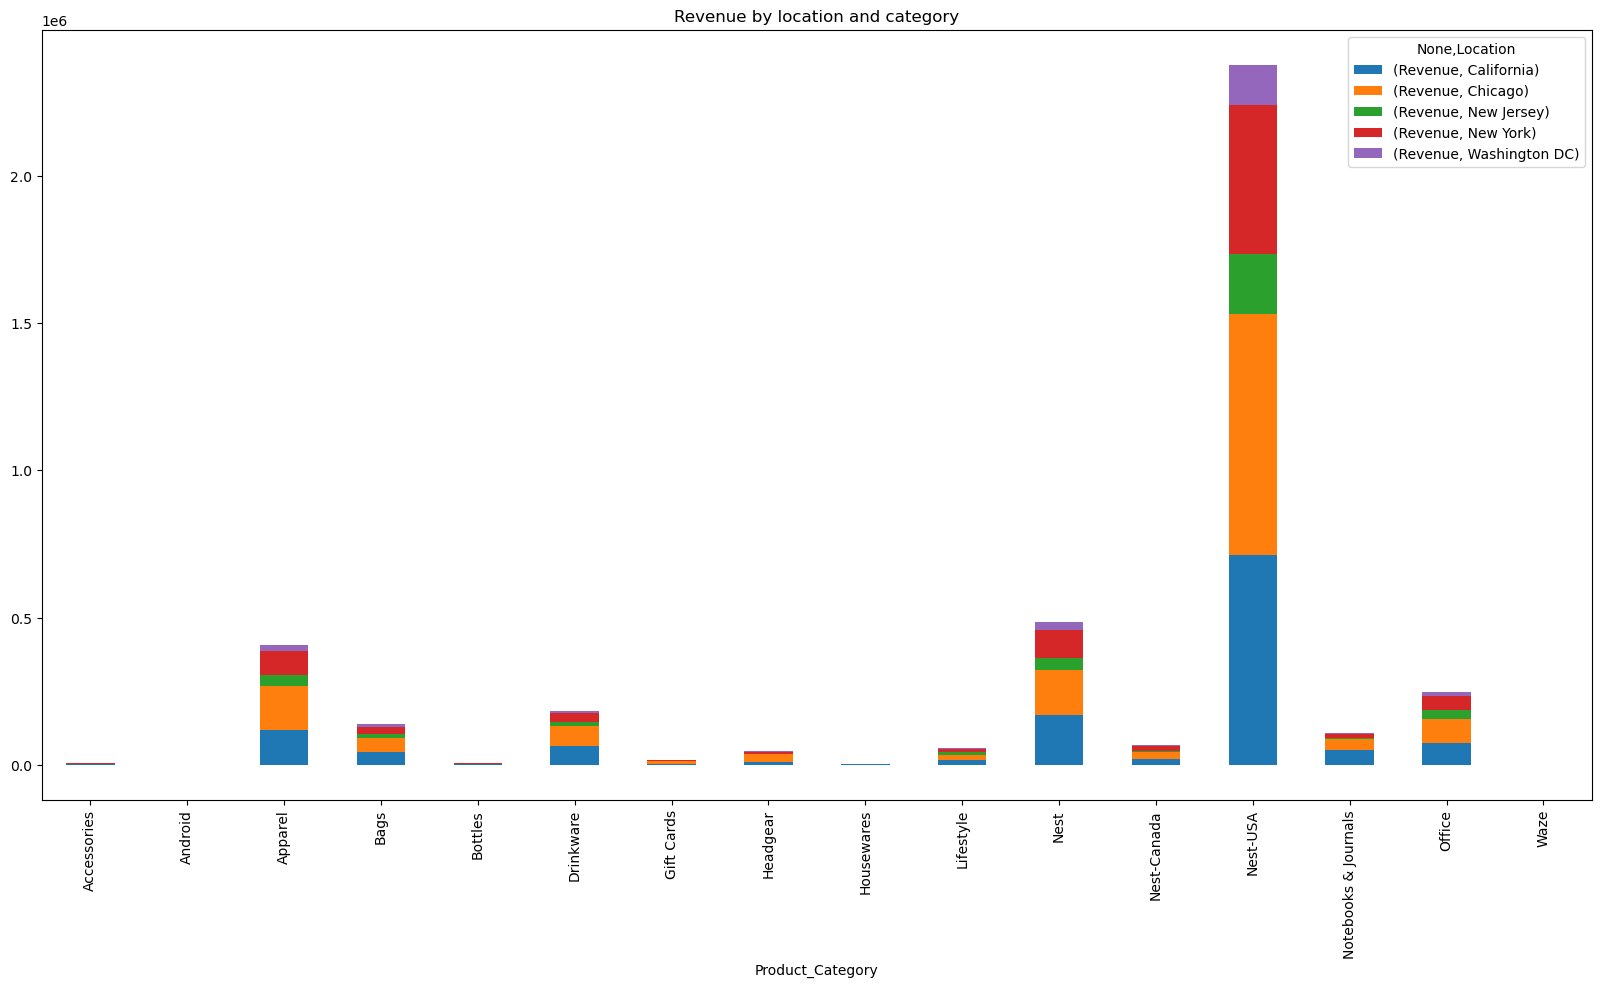

In [375]:
df['Revenue'] = df['Quantity']*df['Avg_Price']*1-df['Discount_pct']*1+df['GST']+df.Delivery_Charges
df.groupby(by=['Product_Category','Location'])[['Revenue']].sum().unstack().plot(kind='bar',stacked=True,figsize=[20,10],title='Revenue by location and category')
plt.show()

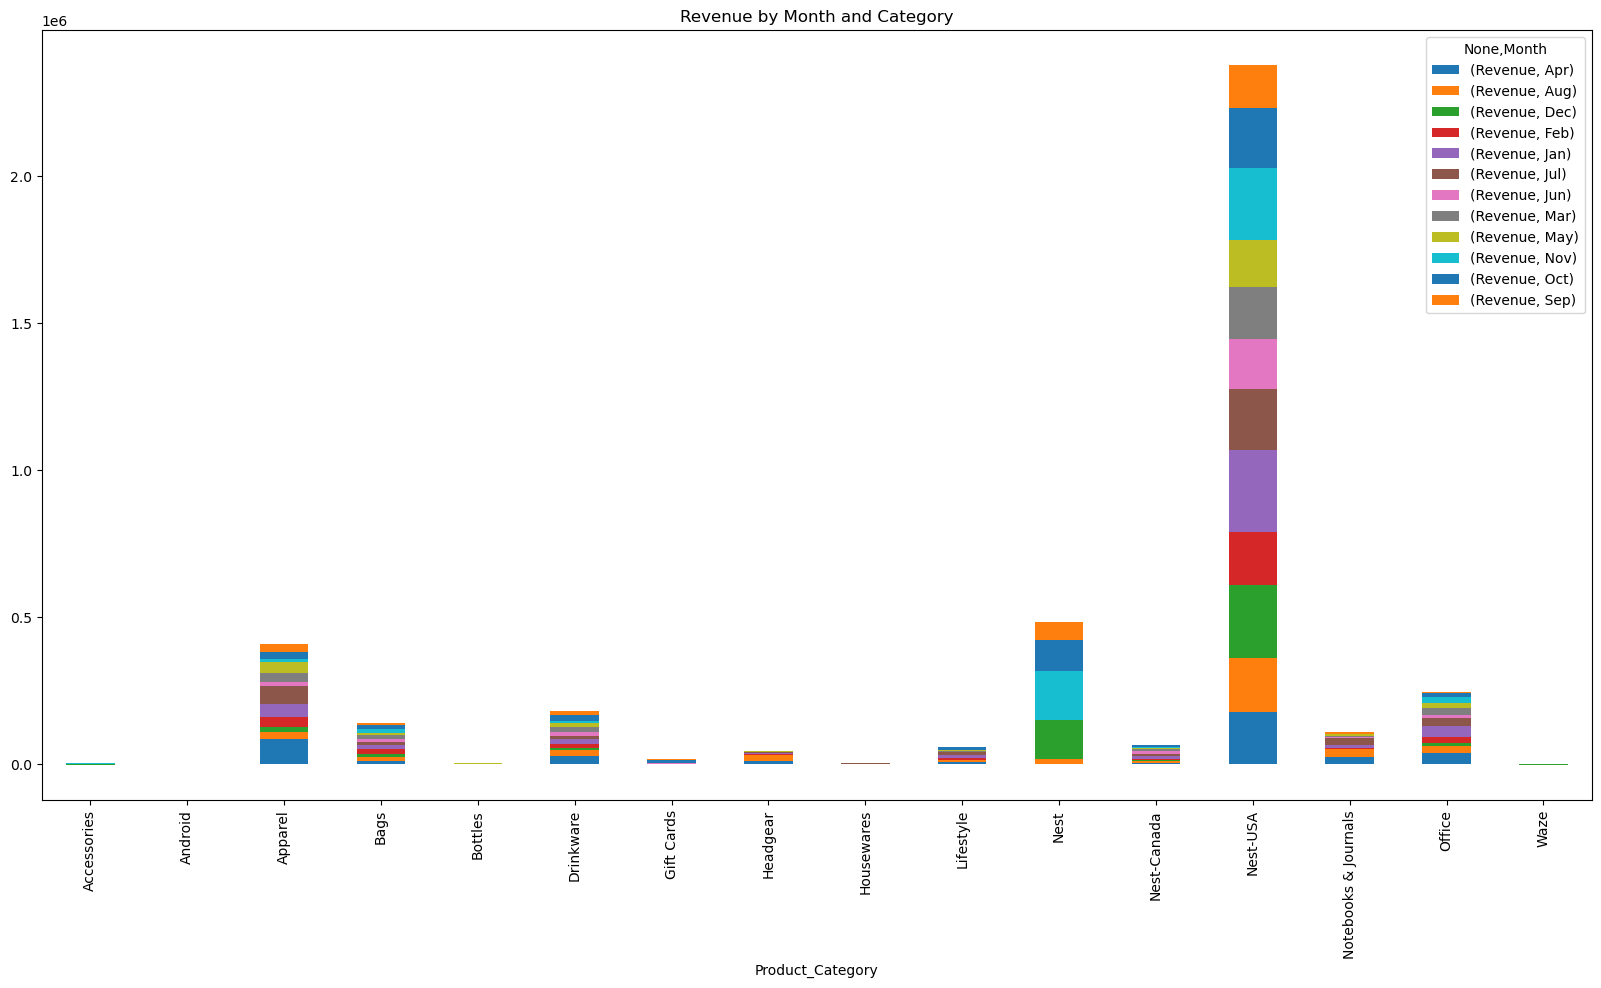

In [376]:
df.groupby(by=['Product_Category','Month'])[['Revenue']].sum().unstack().plot(kind='bar',figsize=[20,10],stacked=True,title='Revenue by Month and Category')
plt.show()

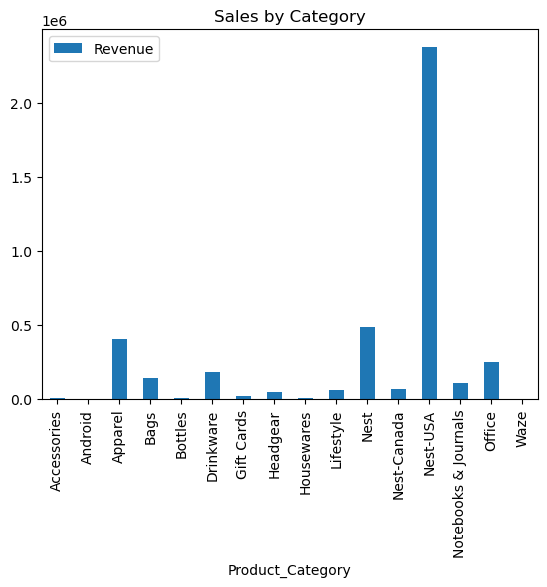

In [377]:
df.groupby(by='Product_Category')[['Revenue']].sum().plot(kind='bar',title='Sales by Category')
plt.show()

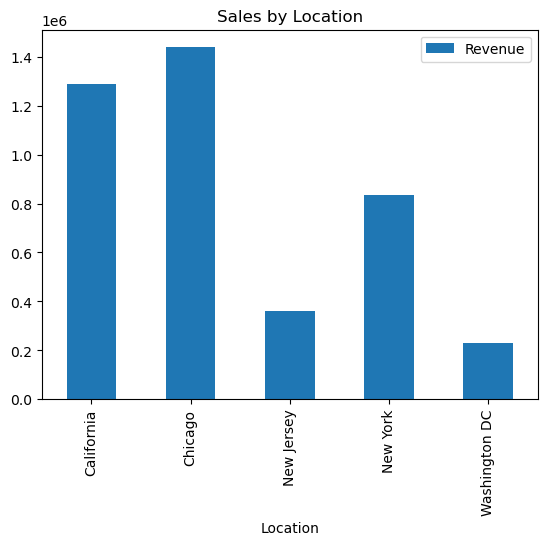

In [378]:
df.groupby(by='Location')[['Revenue']].sum().plot(kind='bar',title='Sales by Location')
plt.show()

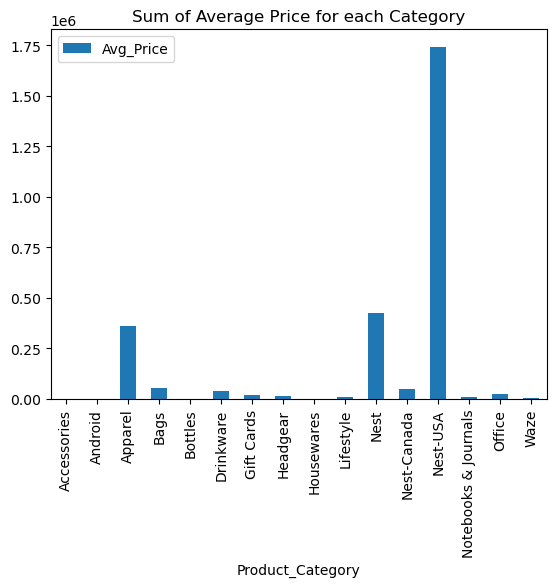

In [379]:
df.groupby(by='Product_Category')[['Avg_Price']].sum().plot(kind='bar',title='Sum of Average Price for each Category')
plt.show()

# g.How number of orders and sales varies by days

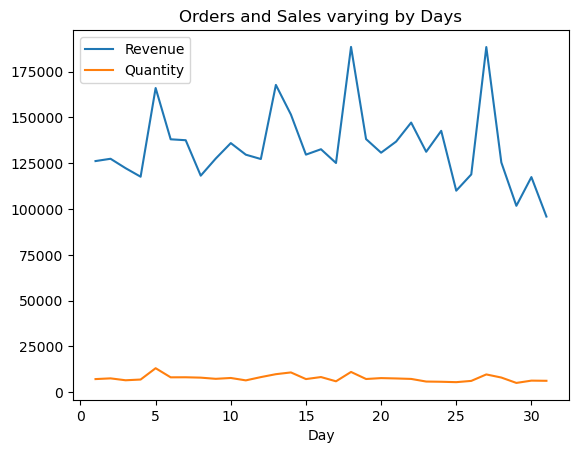

In [380]:
sales= pd.DataFrame(df_fin.groupby('Day').agg({"Revenue": sum , 'Quantity': sum})).reset_index()
sales.plot(x='Day', y= ['Revenue', 'Quantity'], kind ="line",title='Orders and Sales varying by Days')
plt.show()

# h.Calculate the revenue, marketing spend, percentage of marketing spend out of revenue tax, percentages of delivery charges by month.

In [381]:
spend['Month'] = spend.Date.dt.strftime("%b")
spend.head(5)

,Date,Offline_Spend,Online_Spend,Month
0,2019-01-01,4500,2424.50,Jan
1,2019-01-02,4500,3480.36,Jan
2,2019-01-03,4500,1576.38,Jan
3,2019-01-04,4500,2928.55,Jan
4,2019-01-05,4500,4055.30,Jan


In [382]:
Marketing_spend = spend.groupby('Month').agg({'Offline_Spend' : sum, 'Online_Spend' : sum})
Marketing_spend

,Offline_Spend,Online_Spend
Month,,
Apr,96000,61026.83
Aug,85500,57404.15
Dec,122000,76648.75
Feb,81300,55807.92
Jan,96600,58328.95
Jul,67500,52717.85
Jun,80500,53818.14
Mar,73500,48750.09
May,65500,52759.64


In [383]:
revenue_spend=pd.merge(left=df_fin,right=Marketing_spend,on='Month',how='inner')
revenue_spend.head(5)

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Description,Month,Coupon_Code,Transaction_Date,Revenue,Occurence,Day,Week,Offline_Spend,Online_Spend
0,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,New,1,1,96600,58328.95
1,17850,16680,1,153.71,6.5,12,0.1,10,0,0,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Existing,1,1,96600,58328.95
2,13047,16684,2,122.77,6.5,43,0.1,10,0,0,...,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10,2019-01-01,242.14,New,1,1,96600,58328.95
3,13047,16684,1,81.50,6.5,43,0.1,10,0,0,...,Nest Protect Smoke + CO White Wired Alarm-USA,Jan,ELEC10,2019-01-01,78.10,Existing,1,1,96600,58328.95
4,13047,16688,1,122.77,6.5,43,0.1,10,0,0,...,Nest Cam Indoor Security Camera - USA,Jan,ELEC10,2019-01-01,119.37,Existing,1,1,96600,58328.95


In [384]:
revenue_spend['Total_Marketing_Spend'] = revenue_spend.Offline_Spend + revenue_spend.Online_Spend
revenue_spend['%of_marketing_spend_out_of_revenue']= (revenue_spend['Total_Marketing_Spend'] / revenue_spend["Revenue"])*100
revenue_spend.iloc[:,[24,23,22,21,17]]

,Coupon_Status_Used,Coupon_Status_Not Used,Product_Category_Waze,Product_Category_Office,Product_Category_Nest
0,1,0,0,0,0
1,1,0,0,0,0
2,0,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
52519,0,0,0,0,0
52520,1,0,0,0,0
52521,1,0,0,0,0
52522,0,1,0,0,0


In [385]:
revenue_spend['%of_marketing_spend_out_of_revenue_tax']= (revenue_spend['%of_marketing_spend_out_of_revenue'] / revenue_spend["Discount_pct"])*100
revenue_spend.iloc[:,[25,24,23,22,21,17,16]]

,Gender_M,Coupon_Status_Used,Coupon_Status_Not Used,Product_Category_Waze,Product_Category_Office,Product_Category_Nest,Product_Category_Lifestyle
0,1,1,0,0,0,0,0
1,1,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,1,0,0,0,0,0
4,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...
52519,1,0,0,0,0,0,0
52520,0,1,0,0,0,0,0
52521,0,1,0,0,0,0,0
52522,0,0,1,0,0,0,0


In [386]:
deliverycharges=revenue_spend.groupby(by=['Month'])[['Delivery_Charges']].sum()
deliverycharges

,Delivery_Charges
Month,
Apr,40929.78
Aug,60595.00
Dec,37881.99
Feb,48454.28
Jan,58401.75
Jul,48024.13
Jun,37055.84
Mar,59324.29
May,40745.99


In [387]:
deliverycharges['%of_deliverycharges']=(deliverycharges.Delivery_Charges/revenue_spend.Delivery_Charges.sum())* 100
deliverycharges

,Delivery_Charges,%of_deliverycharges
Month,,
Apr,40929.78,7.437858
Aug,60595.00,11.011470
Dec,37881.99,6.884007
Feb,48454.28,8.805229
Jan,58401.75,10.612907
Jul,48024.13,8.727061
Jun,37055.84,6.733877
Mar,59324.29,10.780553
May,40745.99,7.404460


# i.How marketing spend is impacting on revenue

In [388]:
impact=revenue_spend.groupby(by=['Total_Marketing_Spend','Month'])[['Revenue']].sum().reset_index()
impact

,Total_Marketing_Spend,Month,Revenue
0,118259.64,May,255037.48
1,120217.85,Jul,366330.13
2,122250.09,Mar,276918.87
3,134318.14,Jun,231963.28
4,135514.54,Sep,272964.14
5,137107.92,Feb,292319.59
6,142904.15,Aug,338708.96
7,151224.65,Oct,412916.84
8,154928.95,Jan,419756.36
9,157026.83,Apr,397377.83


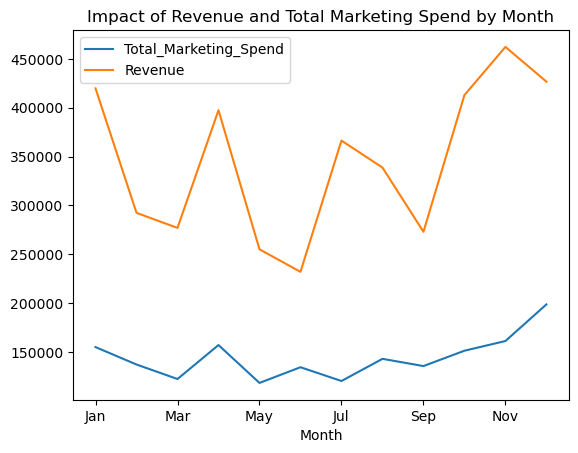

In [389]:
impact.sort_index()
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
impact.index = pd.CategoricalIndex(impact['Month'], categories= sort_order, ordered  = True)
impact =impact.sort_index()
impact.plot(kind ="line",title='Impact of Revenue and Total Marketing Spend by Month')
plt.show()

# j.Which product was appeared in the transactions

In [390]:
df.groupby(by='Product_Category')[['Revenue']].sum().sort_values(by='Revenue',ascending=False).iloc[: :5]

,Revenue
Product_Category,
Nest-USA,2376773.75
Bags,140098.24
Gift Cards,16961.77
Android,202.02


# k.Which product was purcahsed mostly based on the quantity

In [391]:
df.groupby(by=['Product_Category'])[['Quantity']].sum().sort_values(by='Quantity',ascending=False).iloc[::5]

,Quantity
Product_Category,
Office,88383
Bags,15273
Bottles,2090
Android,45


# 3. Performing Customer Segmentation

3.1 Heuristic (Value Based, RFM) - Divide the customers into Premium, Gold, Silver, Standard customers and define strategy on the same.

# VALUE BASED

In [392]:
print('Min Invoice Date:',df_fin.Transaction_Date.dt.date.min(),'max Invoice Date:',
       df_fin.Transaction_Date.dt.date.max())

Min Invoice Date: 2019-01-01 max Invoice Date: 2019-12-31


In [393]:
snapshot_date = df_fin['Transaction_Date'].max() + dt.timedelta(days=1)
snapshot_date
#The last day of purchase in total is 09 DEC, 2011. To calculate the day periods, 
#let's set one day after the last one,or 
#10 DEC as a snapshot_date. We will found the diff days with snapshot_date.

Timestamp('2020-01-01 00:00:00')

In [394]:
# Calculate RFM metrics
rfm = df_fin.groupby(['CustomerID']).agg({'Transaction_Date': lambda x : (snapshot_date - x.max()).days,
                                      'Transaction_ID':'count','Revenue': 'sum'})
#Function Lambdea: it gives the number of days between hypothetical today and the last transaction

#Rename columns
rfm.rename(columns={'Transaction_Date':'Recency','Transaction_ID':'Frequency','Revenue':'MonetaryValue'}
           ,inplace= True)

#Final RFM values
rfm.reset_index(inplace=True)

In [395]:
rfm

,CustomerID,Recency,Frequency,MonetaryValue
0,12346,108,2,121.27
1,12347,60,59,12998.83
2,12348,74,23,1072.69
3,12350,18,17,980.11
4,12356,108,36,1005.30
...,...,...,...,...
1463,18259,271,6,739.53
1464,18260,88,39,2075.54
1465,18269,195,8,54.42
1466,18277,70,1,294.10


In [396]:
rfm.MonetaryValue.quantile([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90])

0.1     110.753
0.2     377.280
0.3     673.638
0.4    1026.852
0.5    1532.705
0.6    2088.666
0.7    2866.326
0.8    4259.488
0.9    6659.308
Name: MonetaryValue, dtype: float64

In [397]:
df_fin1 = pd.merge(df_fin, rfm, on= 'CustomerID', how= "inner")
df_fin1['Deciles'] = pd.qcut(df_fin1.MonetaryValue, 10, labels=False)
df_fin1.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Coupon_Code,Transaction_Date,Revenue,Occurence,Day,Week,Recency,Frequency,MonetaryValue,Deciles
0,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,ELEC10,2019-01-01,150.31,New,1,1,340,293,34643.33,9
1,17850,16680,1,153.71,6.5,12,0.1,10,0,0,...,ELEC10,2019-01-01,150.31,Existing,1,1,340,293,34643.33,9
2,17850,16696,2,122.77,6.5,12,0.1,10,0,0,...,ELEC10,2019-01-01,242.14,Existing,1,1,340,293,34643.33,9
3,17850,16699,1,81.50,6.5,12,0.1,10,0,0,...,ELEC10,2019-01-01,78.10,Existing,1,1,340,293,34643.33,9
4,17850,16700,1,153.71,6.5,12,0.1,10,0,0,...,ELEC10,2019-01-01,150.31,Existing,1,1,340,293,34643.33,9


In [398]:
df_fin1.Deciles.value_counts()

8    5350
4    5335
3    5264
0    5260
2    5257
5    5252
1    5246
6    5232
7    5232
9    5096
Name: Deciles, dtype: int64

In [399]:
df_fin1.groupby('Deciles').agg(np.mean)['MonetaryValue']

Deciles
0      493.040983
1     1386.826685
2     2229.617774
3     3107.587905
4     4192.284553
5     5461.585221
6     7044.859216
7     9165.710424
8    13958.443721
9    42585.180589
Name: MonetaryValue, dtype: float64

In [400]:
# Key performace variable selection
col_kpi=['MonetaryValue','Recency','Frequency','Quantity',
         'GST']
profiling_output= df_fin1.groupby(['Deciles']).apply(lambda x: x[col_kpi].mean()).T
profiling_output

Deciles,0,1,2,3,4,5,6,7,8,9
MonetaryValue,493.040983,1386.826685,2229.617774,3107.587905,4192.284553,5461.585221,7044.859216,9165.710424,13958.443721,42585.180589
Recency,161.610456,149.152688,135.705916,130.369111,119.169072,143.531607,111.608180,75.552561,77.671963,57.049254
Frequency,16.457795,26.579870,35.505612,48.384878,59.774883,72.921935,87.184633,117.655963,167.764860,444.861460
Quantity,3.084601,3.970644,4.092829,4.364552,4.660169,4.126428,4.712347,4.206040,5.205794,6.627747
GST,0.145871,0.140669,0.137953,0.137065,0.133747,0.136596,0.133414,0.135786,0.135585,0.137720


# RFM SEGMENTATION

In [401]:
quantiles = df_fin1[['Frequency','MonetaryValue','Recency' ]].quantile(q=[0.33,0.67])
quantiles

,Frequency,MonetaryValue,Recency
0.33,42.0,2882.40,48.0
0.67,93.0,7275.82,143.0


In [402]:
df_fin1['r_seg'] = np.where(df_fin1.Recency<=48, 'Active', np.where(df_fin1.Recency<=143, 'At Risk', 'Churn'))
df_fin1['f_seg'] = np.where(df_fin1.Frequency<=42, 1, np.where(df_fin1.Frequency<=93, 2, 3))
df_fin1['m_seg'] = np.where(df_fin1.MonetaryValue<=2882.40, 1, np.where(df_fin1.MonetaryValue<=7275.82, 2, 3))
df_fin1.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Occurence,Day,Week,Recency,Frequency,MonetaryValue,Deciles,r_seg,f_seg,m_seg
0,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,New,1,1,340,293,34643.33,9,Churn,3,3
1,17850,16680,1,153.71,6.5,12,0.1,10,0,0,...,Existing,1,1,340,293,34643.33,9,Churn,3,3
2,17850,16696,2,122.77,6.5,12,0.1,10,0,0,...,Existing,1,1,340,293,34643.33,9,Churn,3,3
3,17850,16699,1,81.50,6.5,12,0.1,10,0,0,...,Existing,1,1,340,293,34643.33,9,Churn,3,3
4,17850,16700,1,153.71,6.5,12,0.1,10,0,0,...,Existing,1,1,340,293,34643.33,9,Churn,3,3


In [403]:
df_fin1['fm_seg'] = np.where(((df_fin1.f_seg == 3) & (df_fin1.m_seg ==3)) , 'Platinum',
                          np.where((((df_fin1.f_seg == 3) & (df_fin1.m_seg ==2)) | ((df_fin1.f_seg == 2) & (df_fin1.m_seg ==3))) , 'Gold',
                          np.where((((df_fin1.f_seg == 1) & (df_fin1.m_seg ==3)) | ((df_fin1.f_seg == 3) & (df_fin1.m_seg ==1)) | ((df_fin1.f_seg == 2) & (df_fin1.m_seg ==2))), 'Silver', 'Standard' )))
df_fin1.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Day,Week,Recency,Frequency,MonetaryValue,Deciles,r_seg,f_seg,m_seg,fm_seg
0,17850,16679,1,153.71,6.5,12,0.1,10,0,0,...,1,1,340,293,34643.33,9,Churn,3,3,Platinum
1,17850,16680,1,153.71,6.5,12,0.1,10,0,0,...,1,1,340,293,34643.33,9,Churn,3,3,Platinum
2,17850,16696,2,122.77,6.5,12,0.1,10,0,0,...,1,1,340,293,34643.33,9,Churn,3,3,Platinum
3,17850,16699,1,81.50,6.5,12,0.1,10,0,0,...,1,1,340,293,34643.33,9,Churn,3,3,Platinum
4,17850,16700,1,153.71,6.5,12,0.1,10,0,0,...,1,1,340,293,34643.33,9,Churn,3,3,Platinum


In [404]:
df_fin1[(df_fin1.r_seg=='Active') & (df_fin1.fm_seg == 'Platinum')]

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Day,Week,Recency,Frequency,MonetaryValue,Deciles,r_seg,f_seg,m_seg,fm_seg
442,15311,16748,1,153.71,6.5,40,0.10,10,0,0,...,2,1,13,583,68002.09,9,Active,3,3,Platinum
443,15311,16753,3,81.50,6.5,40,0.10,10,0,0,...,2,1,13,583,68002.09,9,Active,3,3,Platinum
444,15311,16754,1,153.71,6.5,40,0.10,10,0,0,...,2,1,13,583,68002.09,9,Active,3,3,Platinum
445,15311,16755,1,122.77,6.5,40,0.10,10,0,0,...,2,1,13,583,68002.09,9,Active,3,3,Platinum
446,15311,16756,1,153.71,6.5,40,0.10,10,0,0,...,2,1,13,583,68002.09,9,Active,3,3,Platinum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51590,17337,47029,6,24.45,6.0,44,0.18,30,0,0,...,15,50,17,260,30395.20,9,Active,3,3,Platinum
51591,17337,47057,2,24.45,75.0,44,0.18,30,0,0,...,15,50,17,260,30395.20,9,Active,3,3,Platinum
51592,17337,47057,2,24.45,75.0,44,0.18,30,0,0,...,15,50,17,260,30395.20,9,Active,3,3,Platinum
51593,17337,47057,1,24.45,75.0,44,0.18,30,0,0,...,15,50,17,260,30395.20,9,Active,3,3,Platinum


In [405]:
profiling_output= df_fin1.groupby(['r_seg', 'fm_seg']).apply(lambda x: x[col_kpi].mean()).T
profiling_output

r_seg               Active                                          \
fm_seg                Gold      Platinum       Silver     Standard   
MonetaryValue  9400.921282  24956.516456  5318.619029  2145.924339   
Recency          27.966766     20.526243    25.181919    24.600697   
Frequency        84.804154    285.843553    64.628929    26.682230   
Quantity          8.552522      4.665279     3.402225     3.655052   
GST               0.130160      0.136371     0.131513     0.127909   

r_seg              At Risk                                          \
fm_seg                Gold      Platinum       Silver     Standard   
MonetaryValue  7287.382019  21270.942073  4749.712817  1918.625725   
Recency          99.241568     88.522781    91.876170    98.436214   
Frequency        96.429353    245.174973    65.411807    32.269253   
Quantity          4.237466      4.677433     3.883129     4.095091   
GST               0.135734      0.138738     0.137091     0.140457   

r_seg                Churn                                          
fm_seg                Gold      Platinum       Silver     Standard  
MonetaryValue  7247.751660  14414.445707  4855.600962  1719.283643  
Recency         243.511941    223.251904   238.710254   232.154180  
Frequency        92.568892    168.162133    66.103951    27.366561  
Quantity          6.236987      4.735582     5.168862     4.332063  
GST               0.140233      0.139434     0.139219     0.142258

3.2 Scientific (Using K-Means) & Understand the profiles. Define strategy for each segment.

# k-MEANS SEGMENTATION

In [407]:
df_fin.dtypes

CustomerID                                        int64
Transaction_ID                                    int64
Quantity                                          int64
Avg_Price                                       float64
Delivery_Charges                                float64
Tenure_Months                                     int64
GST                                             float64
Discount_pct                                      int64
Product_Category_Android                          uint8
Product_Category_Apparel                          uint8
Product_Category_Bags                             uint8
Product_Category_Bottles                          uint8
Product_Category_Drinkware                        uint8
Product_Category_Gift Cards                       uint8
Product_Category_Headgear                         uint8
Product_Category_Housewares                       uint8
Product_Category_Lifestyle                        uint8
Product_Category_Nest                           

In [408]:
df_fin.drop(['Product_SKU', 'Product_Description','Month','Coupon_Code','Day','Week','Transaction_Date','Occurence'], axis =1, inplace = True)

In [409]:
df_fin # Drop the variables having high cardinility 

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Category_Office,Product_Category_Waze,Coupon_Status_Not Used,Coupon_Status_Used,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Revenue
0,17850,16679,1,153.71,6.5,12,0.10,10,0,0,...,0,0,0,1,1,1,0,0,0,150.31
1,17850,16680,1,153.71,6.5,12,0.10,10,0,0,...,0,0,0,1,1,1,0,0,0,150.31
2,13047,16684,2,122.77,6.5,43,0.10,10,0,0,...,0,0,0,0,1,0,0,0,0,242.14
3,13047,16684,1,81.50,6.5,43,0.10,10,0,0,...,0,0,0,1,1,0,0,0,0,78.10
4,13047,16688,1,122.77,6.5,43,0.10,10,0,0,...,0,0,0,1,1,0,0,0,0,119.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,14044,47224,1,101.93,0.0,49,0.05,30,0,0,...,0,0,0,0,1,0,0,0,0,71.98
52520,15311,47511,2,25.48,0.0,40,0.05,30,0,0,...,0,0,0,1,0,1,0,0,0,21.01
52521,12842,47997,1,254.82,0.0,27,0.05,30,0,0,...,0,0,0,1,0,0,1,0,0,224.87
52522,14462,48062,1,25.48,0.0,42,0.05,30,0,0,...,0,0,1,0,0,1,0,0,0,-4.47


In [410]:
sc = StandardScaler()
std_model = sc.fit(df_fin)
std_model.transform(df_fin)

array([[ 1.41758421, -1.82169208, -0.1736214 , ..., -0.51756041,
        -0.23319779,  0.42710858],
       [ 1.41758421, -1.82157654, -0.1736214 , ..., -0.51756041,
        -0.23319779,  0.42710858],
       [-1.30081931, -1.82111436, -0.12401771, ..., -0.51756041,
        -0.23319779,  0.97766744],
       ...,
       [-1.41684528,  1.79694389, -0.1736214 , ..., -0.51756041,
        -0.23319779,  0.87412664],
       [-0.49995715,  1.80445431, -0.1736214 , ..., -0.51756041,
        -0.23319779, -0.50086158],
       [ 0.26185238,  1.83969551, -0.1736214 , ..., -0.51756041,
        -0.23319779, -0.04251219]])

In [411]:
df_fin_scaled = pd.DataFrame(std_model.transform(df_fin), columns = df_fin.columns)
df_fin_scaled

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Category_Office,Product_Category_Waze,Coupon_Status_Not Used,Coupon_Status_Used,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Revenue
0,1.417584,-1.821692,-0.173621,1.578665,-0.20560,-1.049507,-0.816167,-1.224673,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,1.398012,1.287828,1.370987,-0.304992,-0.51756,-0.233198,0.427109
1,1.417584,-1.821577,-0.173621,1.578665,-0.20560,-1.049507,-0.816167,-1.224673,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,1.398012,1.287828,1.370987,-0.304992,-0.51756,-0.233198,0.427109
2,-1.300819,-1.821114,-0.124018,1.096404,-0.20560,1.251328,-0.816167,-1.224673,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,-0.715301,1.287828,-0.729402,-0.304992,-0.51756,-0.233198,0.977667
3,-1.300819,-1.821114,-0.173621,0.453128,-0.20560,1.251328,-0.816167,-1.224673,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,1.398012,1.287828,-0.729402,-0.304992,-0.51756,-0.233198,-0.005820
4,-1.300819,-1.820652,-0.173621,1.096404,-0.20560,1.251328,-0.816167,-1.224673,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,1.398012,1.287828,-0.729402,-0.304992,-0.51756,-0.233198,0.241610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,-0.736537,1.707628,-0.173621,0.771571,-0.54164,1.696651,-1.906328,1.236199,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,-0.715301,1.287828,-0.729402,-0.304992,-0.51756,-0.233198,-0.042512
52520,-0.019440,1.740789,-0.124018,-0.420055,-0.54164,1.028667,-1.906328,1.236199,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,1.398012,-0.776501,1.370987,-0.304992,-0.51756,-0.233198,-0.348098
52521,-1.416845,1.796944,-0.173621,3.154667,-0.54164,0.063800,-1.906328,1.236199,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,1.398012,-0.776501,-0.729402,3.278770,-0.51756,-0.233198,0.874127
52522,-0.499957,1.804454,-0.173621,-0.420055,-0.54164,1.177108,-1.906328,1.236199,-0.028624,-0.725913,...,-0.376235,-0.103247,2.354619,-0.715301,-0.776501,1.370987,-0.304992,-0.51756,-0.233198,-0.500862


In [412]:
pca_model = PCA(n_components=16)
pca_model = pca_model.fit(df_fin_scaled)
pca_model.explained_variance_  # Eigen values

array([3.0825905 , 1.75869748, 1.44911297, 1.43235558, 1.36505383,
       1.30424126, 1.16847817, 1.16122799, 1.1415828 , 1.0725206 ,
       1.0660948 , 1.04298342, 1.03768817, 1.02149424, 1.01418485,
       1.00701631])

In [413]:
pca_model.explained_variance_ratio_

array([0.09943651, 0.0567311 , 0.04674469, 0.04620414, 0.04403316,
       0.0420715 , 0.03769213, 0.03745825, 0.03682455, 0.03459678,
       0.0343895 , 0.03364399, 0.03347317, 0.0329508 , 0.03271502,
       0.03248378])

In [414]:
np.cumsum(pca_model.explained_variance_ratio_)

array([0.09943651, 0.15616761, 0.2029123 , 0.24911644, 0.29314959,
       0.33522109, 0.37291322, 0.41037147, 0.44719602, 0.4817928 ,
       0.5161823 , 0.54982629, 0.58329946, 0.61625026, 0.64896528,
       0.68144906])

In [415]:
#number of components = 9
pca_model = PCA(n_components=9)

pca_model = pca_model.fit(df_fin_scaled)

In [416]:
pca_model.explained_variance_

array([3.08257405, 1.75404552, 1.43952458, 1.42181113, 1.35397329,
       1.2903233 , 1.16564222, 1.14472225, 1.112281  ])

In [417]:
pca_model.explained_variance_ratio_

array([0.09943598, 0.05658104, 0.04643539, 0.045864  , 0.04367573,
       0.04162254, 0.03760065, 0.03692582, 0.03587935])

In [418]:
sum(pca_model.explained_variance_ratio_)

0.44402049219951584

In [419]:
PCs = pd.DataFrame(pca_model.transform(df_fin_scaled), columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9' ])
PCs   #Pc's can be used for segmentaiton input

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,2.048627,0.028203,1.552066,0.359368,-2.427650,-1.553187,0.094115,0.484753,0.688197
1,2.048638,0.028177,1.552019,0.359377,-2.427607,-1.553186,0.094104,0.484746,0.688191
2,2.020688,0.191401,1.707549,0.190338,-1.488815,-0.114982,0.872462,-0.640579,0.099736
3,1.381122,0.068384,1.481003,-0.309466,-1.594841,-1.611681,0.785171,-0.702443,-0.023675
4,1.772384,-0.029680,1.616525,-0.130151,-1.537084,-1.613850,0.796178,-0.663989,0.021792
...,...,...,...,...,...,...,...,...,...
52519,2.268371,-0.940956,-2.206840,-0.340892,-0.812095,0.164266,0.466652,-0.005804,1.189550
52520,1.569600,-0.626391,-3.029340,-0.008246,-1.635708,-1.280071,-0.369729,1.335774,0.526553
52521,3.699574,-1.332377,-1.352409,0.394387,0.482427,-1.012671,1.135189,0.509673,-1.796941
52522,1.545404,-0.725429,-3.356601,0.036435,-1.964665,2.032480,-0.359789,1.338070,0.567319


In [420]:
#Variable reduction

Loadings =  pd.DataFrame((pca_model.components_.T * np.sqrt(pca_model.explained_variance_)).T,columns=df_fin.columns).T

Loadings.columns= ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9']

Loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
CustomerID,-0.006386,0.009832,0.169433,-0.155748,-0.066121,0.083754,-0.077351,0.080808,0.141226
Transaction_ID,0.167350,-0.294028,-0.486292,0.088298,0.438301,0.014020,-0.101553,-0.065688,-0.051434
Quantity,0.078873,0.684027,0.039170,0.370000,0.290351,0.054582,0.086786,0.057292,-0.031379
Avg_Price,0.850777,-0.342011,0.162565,0.155725,0.015867,-0.016233,-0.016829,0.016513,0.062955
Delivery_Charges,-0.051325,0.496357,0.076940,0.201859,0.151928,-0.019944,0.015197,0.119169,0.169351
Tenure_Months,0.005666,-0.055194,-0.140727,0.035732,-0.097885,-0.019684,0.117172,-0.193060,-0.034752
GST,-0.873293,-0.166601,0.228754,0.346960,0.076958,0.010795,-0.089113,-0.059028,-0.003966
Discount_pct,0.031350,-0.216582,-0.374393,0.144992,0.308185,0.106473,-0.157036,-0.103425,-0.081435
Product_Category_Android,-0.000760,-0.023781,-0.041855,0.005357,-0.047200,0.076380,-0.070918,-0.050863,-0.039248
Product_Category_Apparel,-0.651293,-0.368637,0.087207,0.161427,0.208583,0.004704,0.397113,0.402143,0.104624


In [421]:
Loadings.to_csv('loadings1.csv')

In [422]:
#PCA can be used for any type of business problem (regressin, classificaiton, segmentation)
selected_vars = ['Revenue',
'Avg_Price',
'Location_Chicago',
'Coupon_Status_Used',
'Discount_pct',
'Location_Washington DC',
'Location_New Jersey',
'CustomerID',
'Tenure_Months',
]

In [423]:
final_input_segmentation = df_fin_scaled[selected_vars]   #variable reduction
final_input_segmentation   #These variables can be used for segmentaiton input

,Revenue,Avg_Price,Location_Chicago,Coupon_Status_Used,Discount_pct,Location_Washington DC,Location_New Jersey,CustomerID,Tenure_Months
0,0.427109,1.578665,1.370987,1.398012,-1.224673,-0.233198,-0.304992,1.417584,-1.049507
1,0.427109,1.578665,1.370987,1.398012,-1.224673,-0.233198,-0.304992,1.417584,-1.049507
2,0.977667,1.096404,-0.729402,-0.715301,-1.224673,-0.233198,-0.304992,-1.300819,1.251328
3,-0.005820,0.453128,-0.729402,1.398012,-1.224673,-0.233198,-0.304992,-1.300819,1.251328
4,0.241610,1.096404,-0.729402,1.398012,-1.224673,-0.233198,-0.304992,-1.300819,1.251328
...,...,...,...,...,...,...,...,...,...
52519,-0.042512,0.771571,-0.729402,-0.715301,1.236199,-0.233198,-0.304992,-0.736537,1.696651
52520,-0.348098,-0.420055,1.370987,1.398012,1.236199,-0.233198,-0.304992,-0.019440,1.028667
52521,0.874127,3.154667,-0.729402,1.398012,1.236199,-0.233198,3.278770,-1.416845,0.063800
52522,-0.500862,-0.420055,1.370987,-0.715301,1.236199,-0.233198,-0.304992,-0.499957,1.177108


In [424]:
#Segmentation
km_3 = KMeans(n_clusters=3, random_state=123)
km_3 = km_3.fit(final_input_segmentation)

In [425]:
km_3.labels_

array([0, 0, 0, ..., 0, 2, 0])

In [426]:
km_3.cluster_centers_

array([[ 8.45373458e-01,  1.36993633e+00, -2.29806495e-01,
        -7.51443526e-03,  1.00826801e-02,  6.07992313e-02,
         2.44978083e-02,  1.42902201e-03, -1.25647463e-03],
       [-3.37401275e-01, -5.63539959e-01, -7.29401536e-01,
         6.34598632e-03, -3.46089020e-02,  1.11629292e-01,
         1.77518093e-01,  8.48166767e-03, -8.98625593e-03],
       [-2.33933941e-01, -3.52378701e-01,  1.37098697e+00,
        -3.24948349e-03,  4.59071547e-02, -2.33197793e-01,
        -3.04992380e-01, -1.48081202e-02,  1.54541322e-02]])

In [427]:
#Metrics for segmentation output is good or not
km_3.inertia_  #clsuter errors

379328.7528463829

In [428]:
silhouette_score(final_input_segmentation, km_3.labels_)

0.13101332509286664

In [429]:
#Segment distribution
dd = pd.Series(km_3.labels_)
dd.value_counts()/sum(dd.value_counts())

1    0.454345
2    0.285412
0    0.260243
dtype: float64

In [430]:
km_4 = KMeans(n_clusters=4, random_state=123).fit(final_input_segmentation)
km_5 = KMeans(n_clusters=5, random_state=123).fit(final_input_segmentation)
km_6 = KMeans(n_clusters=6, random_state=123).fit(final_input_segmentation)
km_7 = KMeans(n_clusters=7, random_state=123).fit(final_input_segmentation)
km_8 = KMeans(n_clusters=8, random_state=123).fit(final_input_segmentation)

In [431]:
df_fin['cluster_3'] = km_3.labels_
df_fin['cluster_4'] = km_4.labels_
df_fin['cluster_5'] = km_5.labels_
df_fin['cluster_6'] = km_6.labels_
df_fin['cluster_7'] = km_7.labels_
df_fin['cluster_8'] = km_8.labels_

In [432]:
# calculate SC for K=3 through K=9
k_range = range(3, 9)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(final_input_segmentation)
    scores.append(silhouette_score(final_input_segmentation, km.labels_))

In [433]:
scores

[0.13101332509286664,
 0.20543900476140653,
 0.19250870223215824,
 0.18702083861035732,
 0.19738404631411166,
 0.22024408914203497]

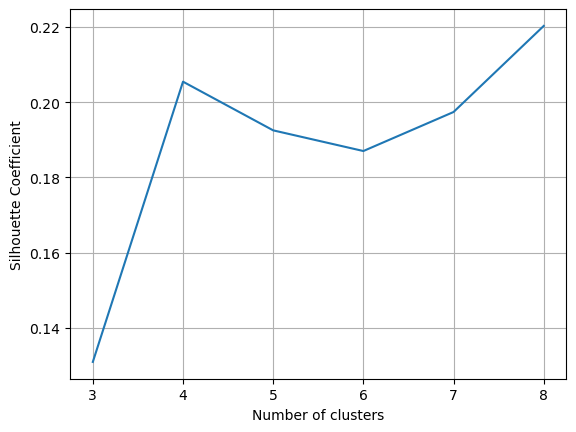

In [434]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [437]:
#based on sc score, the solution K=4, the second solution can be k=8
df_fin.cluster_3.value_counts()/sum(df_fin.cluster_3.value_counts())

1    0.454345
2    0.285412
0    0.260243
Name: cluster_3, dtype: float64

In [438]:
sum(df_fin.cluster_5.value_counts())

52524

In [439]:
df_fin.cluster_4.value_counts()/sum(df_fin.cluster_3.value_counts())

0    0.516050
1    0.347270
2    0.085104
3    0.051576
Name: cluster_4, dtype: float64

In [440]:
df_fin.cluster_5.value_counts()/sum(df_fin.cluster_3.value_counts())

1    0.362882
0    0.284460
2    0.216967
3    0.084133
4    0.051557
Name: cluster_5, dtype: float64

In [441]:
#Profiling
size=pd.concat([pd.Series(df_fin.cluster_3.size), pd.Series.sort_index(df_fin.cluster_3.value_counts()), pd.Series.sort_index(df_fin.cluster_4.value_counts()),
           pd.Series.sort_index(df_fin.cluster_5.value_counts()), pd.Series.sort_index(df_fin.cluster_6.value_counts()),
           pd.Series.sort_index(df_fin.cluster_7.value_counts()), pd.Series.sort_index(df_fin.cluster_8.value_counts())])

In [442]:
size

0    52524
0    13669
1    23864
2    14991
0    27105
1    18240
2     4470
3     2709
0    14941
1    19060
2    11396
3     4419
4     2708
0     9920
1    12895
2     9937
3     2708
4    12649
5     4415
0     9256
1    11909
2     4415
3    12891
4    11308
5     2707
6       38
0    12629
1     7679
2     2707
3     4415
4     6046
5     7638
6       34
7    11376
dtype: int64

In [443]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/df_fin.cluster_3.size, columns=['Seg_Pct'])
Seg_Pct.T

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_Pct,1.0,0.260243,0.454345,0.285412,0.51605,0.34727,0.085104,0.051576,0.28446,0.362882,...,0.051538,0.000723,0.240442,0.1462,0.051538,0.084057,0.115109,0.145419,0.000647,0.216587


In [444]:
df_fin.apply(np.mean).T

CustomerID                               15345.347213
Transaction_ID                           32445.093367
Quantity                                     4.500171
Avg_Price                                   52.429089
Delivery_Charges                            10.476922
Tenure_Months                               26.140393
GST                                          0.137433
Discount_pct                                19.953164
Product_Category_Android                     0.000819
Product_Category_Apparel                     0.345099
Product_Category_Bags                        0.035831
Product_Category_Bottles                     0.005102
Product_Category_Drinkware                   0.066313
Product_Category_Gift Cards                  0.003027
Product_Category_Headgear                    0.014679
Product_Category_Housewares                  0.002323
Product_Category_Lifestyle                   0.058868
Product_Category_Nest                        0.041848
Product_Category_Nest-Canada

In [445]:
df_fin.groupby('cluster_4').apply(np.mean).T

C:\Users\Deepika\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


cluster_4,0,1,2,3
CustomerID,15364.324737,15329.459594,15124.271365,15627.227390
Transaction_ID,32299.156798,32648.853673,33067.292841,31506.662606
Quantity,4.364988,4.568531,5.023490,4.528977
Avg_Price,52.162480,52.094662,53.327635,55.865740
Delivery_Charges,10.672612,10.453188,9.497414,10.294983
Tenure_Months,26.007600,26.258224,25.974720,26.949059
GST,0.137224,0.137555,0.138515,0.136925
Discount_pct,19.745434,20.322368,20.252796,19.051310
Product_Category_Android,0.000738,0.000987,0.000895,0.000369
Product_Category_Apparel,0.346541,0.337610,0.363982,0.349945


In [446]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each cluster
Profling_output = pd.concat([df_fin.apply(lambda x: x.mean()).T, df_fin.groupby('cluster_3').apply(lambda x: x.mean()).T, df_fin.groupby('cluster_4').apply(lambda x: x.mean()).T,
          df_fin.groupby('cluster_5').apply(lambda x: x.mean()).T, df_fin.groupby('cluster_6').apply(lambda x: x.mean()).T,
          df_fin.groupby('cluster_7').apply(lambda x: x.mean()).T, df_fin.groupby('cluster_8').apply(lambda x: x.mean()).T], axis=1)

Profling_output

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
CustomerID,15345.347213,15347.988660,15360.333012,15319.082983,15364.324737,15329.459594,15124.271365,15627.227390,15321.024697,15388.426967,...,15627.431474,14636.921053,15380.197561,15306.291444,15627.431474,15123.968743,15340.644889,15395.606834,14548.764706,15322.949103
Transaction_ID,32445.093367,33618.944253,31877.545885,32278.232273,32299.156798,32648.853673,33067.292841,31506.662606,32280.132320,31801.505771,...,31514.887699,29709.447368,31820.764431,34048.486131,31514.887699,32951.164213,32528.555243,31914.502618,28927.235294,32403.216596
Quantity,4.500171,4.814690,4.428512,4.327463,4.364988,4.568531,5.023490,4.528977,4.249649,4.506506,...,4.162911,318.631579,4.734104,3.904024,4.162911,4.450283,4.325339,4.310422,332.176471,3.983474
Avg_Price,52.429089,140.327845,16.274598,29.835711,52.162480,52.094662,53.327635,55.865740,29.705279,16.430763,...,55.902959,17.521579,16.885448,150.664045,55.902959,50.054960,48.011088,29.497230,17.778824,43.520449
Delivery_Charges,10.476922,9.112519,11.044035,10.818223,10.672612,10.453188,9.497414,10.294983,10.774262,11.220949,...,10.297787,42.491316,11.499538,9.104221,10.297787,9.525955,10.293296,10.893877,43.074412,10.400180
Tenure_Months,26.140393,26.121662,26.019318,26.350210,26.007600,26.258224,25.974720,26.949059,26.335787,25.883106,...,26.947543,31.921053,25.827777,26.257455,26.947543,25.962627,26.296064,25.976434,30.823529,26.298699
GST,0.137433,0.095395,0.155611,0.146827,0.137224,0.137555,0.138515,0.136925,0.146951,0.155028,...,0.136923,0.124211,0.154576,0.092745,0.136923,0.139524,0.139251,0.146699,0.120000,0.140743
Discount_pct,19.953164,20.033653,19.671891,20.327530,19.745434,20.322368,20.252796,19.051310,20.319256,19.592865,...,19.050610,16.578947,19.581123,20.231801,19.050610,20.246886,20.274562,19.625556,15.294118,20.341948
Product_Category_Android,0.000819,0.000000,0.001048,0.001201,0.000738,0.000987,0.000895,0.000369,0.001205,0.001049,...,0.000369,0.000000,0.001109,0.000000,0.000369,0.000906,0.000496,0.000786,0.000000,0.001319
Product_Category_Apparel,0.345099,0.011340,0.496564,0.408312,0.346541,0.337610,0.363982,0.349945,0.409410,0.488615,...,0.350203,0.236842,0.486183,0.009246,0.350203,0.368516,0.346179,0.418303,0.264706,0.355397


In [447]:
Profling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output], axis=0)
Profling_output_final

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,52524.000000,13669.000000,23864.000000,14991.000000,27105.000000,18240.000000,4470.000000,2709.000000,14941.000000,19060.000000,...,2707.000000,38.000000,12629.000000,7679.000000,2707.000000,4415.000000,6046.000000,7638.000000,34.000000,11376.000000
Seg_Pct,1.000000,0.260243,0.454345,0.285412,0.516050,0.347270,0.085104,0.051576,0.284460,0.362882,...,0.051538,0.000723,0.240442,0.146200,0.051538,0.084057,0.115109,0.145419,0.000647,0.216587
CustomerID,15345.347213,15347.988660,15360.333012,15319.082983,15364.324737,15329.459594,15124.271365,15627.227390,15321.024697,15388.426967,...,15627.431474,14636.921053,15380.197561,15306.291444,15627.431474,15123.968743,15340.644889,15395.606834,14548.764706,15322.949103
Transaction_ID,32445.093367,33618.944253,31877.545885,32278.232273,32299.156798,32648.853673,33067.292841,31506.662606,32280.132320,31801.505771,...,31514.887699,29709.447368,31820.764431,34048.486131,31514.887699,32951.164213,32528.555243,31914.502618,28927.235294,32403.216596
Quantity,4.500171,4.814690,4.428512,4.327463,4.364988,4.568531,5.023490,4.528977,4.249649,4.506506,...,4.162911,318.631579,4.734104,3.904024,4.162911,4.450283,4.325339,4.310422,332.176471,3.983474
Avg_Price,52.429089,140.327845,16.274598,29.835711,52.162480,52.094662,53.327635,55.865740,29.705279,16.430763,...,55.902959,17.521579,16.885448,150.664045,55.902959,50.054960,48.011088,29.497230,17.778824,43.520449
Delivery_Charges,10.476922,9.112519,11.044035,10.818223,10.672612,10.453188,9.497414,10.294983,10.774262,11.220949,...,10.297787,42.491316,11.499538,9.104221,10.297787,9.525955,10.293296,10.893877,43.074412,10.400180
Tenure_Months,26.140393,26.121662,26.019318,26.350210,26.007600,26.258224,25.974720,26.949059,26.335787,25.883106,...,26.947543,31.921053,25.827777,26.257455,26.947543,25.962627,26.296064,25.976434,30.823529,26.298699
GST,0.137433,0.095395,0.155611,0.146827,0.137224,0.137555,0.138515,0.136925,0.146951,0.155028,...,0.136923,0.124211,0.154576,0.092745,0.136923,0.139524,0.139251,0.146699,0.120000,0.140743
Discount_pct,19.953164,20.033653,19.671891,20.327530,19.745434,20.322368,20.252796,19.051310,20.319256,19.592865,...,19.050610,16.578947,19.581123,20.231801,19.050610,20.246886,20.274562,19.625556,15.294118,20.341948


In [448]:
#Profling_output_final.columns = ['Seg_' + str(i) for i in Profling_output_final.columns]
Profling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]
Profling_output_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,52524.000000,13669.000000,23864.000000,14991.000000,27105.000000,18240.000000,4470.000000,2709.000000,14941.000000,19060.000000,...,2707.000000,38.000000,12629.000000,7679.000000,2707.000000,4415.000000,6046.000000,7638.000000,34.000000,11376.000000
Seg_Pct,1.000000,0.260243,0.454345,0.285412,0.516050,0.347270,0.085104,0.051576,0.284460,0.362882,...,0.051538,0.000723,0.240442,0.146200,0.051538,0.084057,0.115109,0.145419,0.000647,0.216587
CustomerID,15345.347213,15347.988660,15360.333012,15319.082983,15364.324737,15329.459594,15124.271365,15627.227390,15321.024697,15388.426967,...,15627.431474,14636.921053,15380.197561,15306.291444,15627.431474,15123.968743,15340.644889,15395.606834,14548.764706,15322.949103
Transaction_ID,32445.093367,33618.944253,31877.545885,32278.232273,32299.156798,32648.853673,33067.292841,31506.662606,32280.132320,31801.505771,...,31514.887699,29709.447368,31820.764431,34048.486131,31514.887699,32951.164213,32528.555243,31914.502618,28927.235294,32403.216596
Quantity,4.500171,4.814690,4.428512,4.327463,4.364988,4.568531,5.023490,4.528977,4.249649,4.506506,...,4.162911,318.631579,4.734104,3.904024,4.162911,4.450283,4.325339,4.310422,332.176471,3.983474
Avg_Price,52.429089,140.327845,16.274598,29.835711,52.162480,52.094662,53.327635,55.865740,29.705279,16.430763,...,55.902959,17.521579,16.885448,150.664045,55.902959,50.054960,48.011088,29.497230,17.778824,43.520449
Delivery_Charges,10.476922,9.112519,11.044035,10.818223,10.672612,10.453188,9.497414,10.294983,10.774262,11.220949,...,10.297787,42.491316,11.499538,9.104221,10.297787,9.525955,10.293296,10.893877,43.074412,10.400180
Tenure_Months,26.140393,26.121662,26.019318,26.350210,26.007600,26.258224,25.974720,26.949059,26.335787,25.883106,...,26.947543,31.921053,25.827777,26.257455,26.947543,25.962627,26.296064,25.976434,30.823529,26.298699
GST,0.137433,0.095395,0.155611,0.146827,0.137224,0.137555,0.138515,0.136925,0.146951,0.155028,...,0.136923,0.124211,0.154576,0.092745,0.136923,0.139524,0.139251,0.146699,0.120000,0.140743
Discount_pct,19.953164,20.033653,19.671891,20.327530,19.745434,20.322368,20.252796,19.051310,20.319256,19.592865,...,19.050610,16.578947,19.581123,20.231801,19.050610,20.246886,20.274562,19.625556,15.294118,20.341948


In [449]:
Profling_output_final.to_csv('Profling_output_final.csv')

# ELBOW ANALYSIS

In [450]:
cluster_range = range( 1, 12 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( df_fin_scaled )
    cluster_errors.append( clusters.inertia_ )

In [451]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df

,num_clusters,cluster_errors
0,1,1.628244e+06
1,2,1.484531e+06
2,3,1.397909e+06
3,4,1.333304e+06
4,5,1.284742e+06
5,6,1.215471e+06
6,7,1.166497e+06
7,8,1.108045e+06
8,9,1.049808e+06
9,10,1.018365e+06


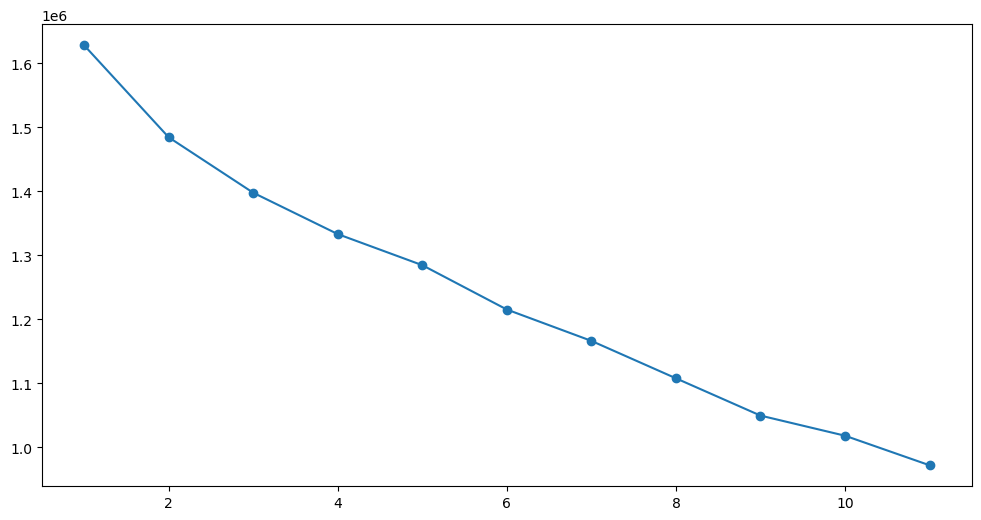

In [452]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

NOTE:
    
The elbow diagram shows that the gain in explained variance reduces significantly from 3 to 4 to 5. So, optimal number of clusters could either 4 or 5.


The actual number of clusters chosen can be finally based on business context and convenience of dealing with number of segments or clusters.

In [453]:
import pickle

# now you can save it to a file
with open('km_4model.pkl', 'wb') as f:
    pickle.dump(km_4, f)

# 4. Predicting Customer Lifetime Value (Low Value/Medium Value/High Value)

In [140]:
rfm

,CustomerID,Recency,Frequency,MonetaryValue
0,12346,108,2,121.27
1,12347,60,59,12998.83
2,12348,74,23,1072.69
3,12350,18,17,980.11
4,12356,108,36,1005.30
...,...,...,...,...
1463,18259,271,6,739.53
1464,18260,88,39,2075.54
1465,18269,195,8,54.42
1466,18277,70,1,294.10


In [141]:
quantiles_1 = rfm[['MonetaryValue' ]].quantile(q=[0.33,0.67])
quantiles_1

,MonetaryValue
0.33,755.3872
0.67,2624.7315


In [142]:
# Creating dependent variable 
rfm['Customer_flag_based_on_revenue'] = np.where(rfm.MonetaryValue<=755.3872, 'Low_Value', np.where(rfm.MonetaryValue<=2624.7315, "Medium_Value", "High_Value"))
rfm

,CustomerID,Recency,Frequency,MonetaryValue,Customer_flag_based_on_revenue
0,12346,108,2,121.27,Low_Value
1,12347,60,59,12998.83,High_Value
2,12348,74,23,1072.69,Medium_Value
3,12350,18,17,980.11,Medium_Value
4,12356,108,36,1005.30,Medium_Value
...,...,...,...,...,...
1463,18259,271,6,739.53,Low_Value
1464,18260,88,39,2075.54,Medium_Value
1465,18269,195,8,54.42,Low_Value
1466,18277,70,1,294.10,Low_Value


In [143]:
df.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status', 'Gender', 'Location',
       'Tenure_Months', 'GST', 'Month', 'Coupon_Code', 'Discount_pct',
       'Revenue'],
      dtype='object')

In [151]:
customer_level_data = df.groupby(['CustomerID','Location','Gender']).agg({'Transaction_Date': min, 'Quantity' : sum, 'Avg_Price': sum , 'Delivery_Charges' : sum , 'GST' : sum}).reset_index()
customer_level_data

,CustomerID,Location,Gender,Transaction_Date,Quantity,Avg_Price,Delivery_Charges,GST
0,12346,New York,F,2019-09-15,3,25.49,150.00,0.28
1,12347,New York,M,2019-03-24,340,3734.97,658.64,7.67
2,12348,California,M,2019-06-22,209,336.52,197.15,3.42
3,12350,California,M,2019-12-14,21,1312.40,127.88,2.16
4,12356,Chicago,F,2019-09-15,56,1244.83,637.49,5.34
...,...,...,...,...,...,...,...,...
1463,18259,California,F,2019-04-05,45,67.14,271.83,0.95
1464,18260,New York,M,2019-06-22,128,1111.29,614.06,5.23
1465,18269,Chicago,M,2019-04-05,10,89.34,51.50,1.36
1466,18277,Chicago,F,2019-10-23,2,149.00,6.00,0.10


In [152]:
data_final = pd.merge(customer_level_data, rfm, on = "CustomerID", how= "left")
data_final.Customer_flag_based_on_revenue.value_counts()

Medium_Value    498
Low_Value       485
High_Value      485
Name: Customer_flag_based_on_revenue, dtype: int64

In [153]:
data_final.isna().sum()

CustomerID                        0
Location                          0
Gender                            0
Transaction_Date                  0
Quantity                          0
Avg_Price                         0
Delivery_Charges                  0
GST                               0
Recency                           0
Frequency                         0
MonetaryValue                     0
Customer_flag_based_on_revenue    0
dtype: int64

In [154]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 0 to 1467
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   CustomerID                      1468 non-null   int64         
 1   Location                        1468 non-null   object        
 2   Gender                          1468 non-null   object        
 3   Transaction_Date                1468 non-null   datetime64[ns]
 4   Quantity                        1468 non-null   int64         
 5   Avg_Price                       1468 non-null   float64       
 6   Delivery_Charges                1468 non-null   float64       
 7   GST                             1468 non-null   float64       
 8   Recency                         1468 non-null   int64         
 9   Frequency                       1468 non-null   int64         
 10  MonetaryValue                   1468 non-null   float64       
 11  Cust

In [155]:
data_final.duplicated().sum()

0

In [156]:
data_final.nunique()

CustomerID                        1468
Location                             5
Gender                               2
Transaction_Date                   345
Quantity                           440
Avg_Price                         1443
Delivery_Charges                  1150
GST                                775
Recency                            335
Frequency                          162
MonetaryValue                     1463
Customer_flag_based_on_revenue       3
dtype: int64

In [157]:
data_final.drop(['CustomerID', 'Transaction_Date'], axis =1 , inplace = True) # Dropping variables 'CustomerID', 'Transaction_Date'
data_final.head()


,Location,Gender,Quantity,Avg_Price,Delivery_Charges,GST,Recency,Frequency,MonetaryValue,Customer_flag_based_on_revenue
0,New York,F,3,25.49,150.00,0.28,108,2,121.27,Low_Value
1,New York,M,340,3734.97,658.64,7.67,60,59,12998.83,High_Value
2,California,M,209,336.52,197.15,3.42,74,23,1072.69,Medium_Value
3,California,M,21,1312.40,127.88,2.16,18,17,980.11,Medium_Value
4,Chicago,F,56,1244.83,637.49,5.34,108,36,1005.30,Medium_Value


In [158]:
data_final = create_dummies(data_final, ['Location','Gender'])
data_final

,Quantity,Avg_Price,Delivery_Charges,GST,Recency,Frequency,MonetaryValue,Customer_flag_based_on_revenue,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Gender_F,Gender_M
0,3,25.49,150.00,0.28,108,2,121.27,Low_Value,0,0,1,0,1,0
1,340,3734.97,658.64,7.67,60,59,12998.83,High_Value,0,0,1,0,0,1
2,209,336.52,197.15,3.42,74,23,1072.69,Medium_Value,0,0,0,0,0,1
3,21,1312.40,127.88,2.16,18,17,980.11,Medium_Value,0,0,0,0,0,1
4,56,1244.83,637.49,5.34,108,36,1005.30,Medium_Value,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,45,67.14,271.83,0.95,271,6,739.53,Low_Value,0,0,0,0,1,0
1464,128,1111.29,614.06,5.23,88,39,2075.54,Medium_Value,0,0,1,0,0,1
1465,10,89.34,51.50,1.36,195,8,54.42,Low_Value,1,0,0,0,0,1
1466,2,149.00,6.00,0.10,70,1,294.10,Low_Value,1,0,0,0,1,0


In [159]:
#splitting 
X = data_final.drop(columns = ['Customer_flag_based_on_revenue'])
y = data_final["Customer_flag_based_on_revenue"]

In [160]:
#Encoder for y variable
enc =LabelEncoder()
y = enc.fit_transform(y)
X

,Quantity,Avg_Price,Delivery_Charges,GST,Recency,Frequency,MonetaryValue,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Gender_F,Gender_M
0,3,25.49,150.00,0.28,108,2,121.27,0,0,1,0,1,0
1,340,3734.97,658.64,7.67,60,59,12998.83,0,0,1,0,0,1
2,209,336.52,197.15,3.42,74,23,1072.69,0,0,0,0,0,1
3,21,1312.40,127.88,2.16,18,17,980.11,0,0,0,0,0,1
4,56,1244.83,637.49,5.34,108,36,1005.30,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,45,67.14,271.83,0.95,271,6,739.53,0,0,0,0,1,0
1464,128,1111.29,614.06,5.23,88,39,2075.54,0,0,1,0,0,1
1465,10,89.34,51.50,1.36,195,8,54.42,1,0,0,0,0,1
1466,2,149.00,6.00,0.10,70,1,294.10,1,0,0,0,1,0


In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [162]:
from sklearn.svm import SVC

param_grid = {'C': [1]}
grid = GridSearchCV(SVC(), param_grid)

grid.fit(X_train, y_train)
print(grid.best_params_)

{'C': 1}


In [163]:
model = grid.best_estimator_
yfit = model.predict(X_test)

In [164]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yfit))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       112
           1       0.96      0.99      0.97        90
           2       0.94      0.95      0.94        92

    accuracy                           0.96       294
   macro avg       0.96      0.96      0.96       294
weighted avg       0.96      0.96      0.96       294



# XGBOOST MODEL

In [168]:
import xgboost as xgb
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)


Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 1.00


In [169]:
from sklearn.model_selection import cross_val_score

cross_val=cross_val_score(ltv_xgb_model,X,y,cv=10,scoring='accuracy').mean()

In [170]:
cross_val

0.9979591836734695

In [171]:
filename = 'SimpleXgboost'
pickle.dump(ltv_xgb_model, open(filename, 'wb'))

# TUNING XGB MODEL

In [173]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [174]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [175]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [177]:
random_classifier = xgb.XGBClassifier()
random_search=RandomizedSearchCV(random_classifier,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [178]:
from sklearn import preprocessing
z = preprocessing.label_binarize(y, classes=[0, 1, 2, 3])

In [179]:
random_search.fit(X, y)
print(random_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.4, 'colsample_bytree': 0.3}


In [180]:
random_search.best_score_

0.9972789115646258

In [181]:
tuned_xgb = xgb.XGBClassifier(min_child_weight=5,max_depth=4,learning_rate=0.05,gamma=0.0,colsample_bytree=0.4)

In [182]:
tuned_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [183]:
y_pred = tuned_xgb.predict(X_test)
y_pred

array([2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 2, 0, 0, 2, 0, 1, 1, 1, 1, 0, 2, 2,
       1, 0, 0, 2, 2, 2, 1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 1, 0,
       0, 1, 0, 2, 1, 2, 2, 0, 0, 0, 1, 2, 2, 1, 2, 1, 2, 2, 0, 1, 0, 0,
       0, 2, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 1, 2, 1, 2, 2,
       1, 2, 1, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 1, 2, 2, 1, 1, 0, 0, 1, 0,
       0, 0, 2, 2, 0, 1, 0, 0, 1, 2, 1, 1, 2, 0, 1, 2, 1, 2, 2, 0, 2, 2,
       0, 0, 0, 0, 1, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 2, 2, 1, 2, 1, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 1, 2,
       0, 2, 0, 2, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2,
       0, 1, 0, 2, 0, 2, 1, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 2, 0, 1, 2, 2,
       1, 2, 0, 2, 1, 0, 0, 1, 0, 2, 0, 1, 2, 0, 2, 0, 2, 0, 2, 1, 2, 1,
       2, 2, 1, 1, 2, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 2, 0, 0, 2, 0, 0,
       0, 2, 1, 1, 2, 2, 1, 0, 2, 1, 1, 2, 0, 1, 1, 2, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 1, 2, 0, 1, 0], dtype=int64)

In [184]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test, y_pred)

accuracy_score=accuracy_score(y_test,y_pred)
accuracy_score

1.0

In [185]:
from sklearn.model_selection import cross_val_score

cross_val=cross_val_score(tuned_xgb,X,y,cv=10,scoring='accuracy').mean()

In [186]:
cross_val

0.9979591836734695

In [187]:
filename = 'TunedXgboost'
pickle.dump(tuned_xgb, open(filename, 'wb'))

# 5. Cross-Selling (Which products are selling together)

In [200]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [201]:
df3=df
df3.head(2)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,Month,Coupon_Code,Discount_pct,Revenue
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31


In [202]:
# Clean up spaces in description and remove any rows that don't have a valid invoice
df3['Product_Description'] = df3['Product_Description'].str.strip()
df3.dropna(axis=0, subset=['Transaction_ID'], inplace=True)
df3

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,Month,Coupon_Code,Discount_pct,Revenue
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.10,Jan,ELEC10,10,150.31
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.10,Jan,ELEC10,10,150.31
2,13047,16684,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2,122.77,6.5,Clicked,M,California,43,0.10,Jan,ELEC10,10,242.14
3,13047,16684,2019-01-01,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,1,81.50,6.5,Used,M,California,43,0.10,Jan,ELEC10,10,78.10
4,13047,16688,2019-01-01,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,122.77,6.5,Used,M,California,43,0.10,Jan,ELEC10,10,119.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,14044,47224,2019-12-17,GGOEGGCX056199,Gift Card- $100.00,Gift Cards,1,101.93,0.0,Clicked,M,California,49,0.05,Dec,GC30,30,71.98
52520,15311,47511,2019-12-19,GGOEGGCX056299,Gift Card - $25.00,Gift Cards,2,25.48,0.0,Used,F,Chicago,40,0.05,Dec,GC30,30,21.01
52521,12842,47997,2019-12-23,GGOEGGCX056399,Gift Card - $250.00,Gift Cards,1,254.82,0.0,Used,F,New Jersey,27,0.05,Dec,GC30,30,224.87
52522,14462,48062,2019-12-25,GGOEGGCX056299,Gift Card - $25.00,Gift Cards,1,25.48,0.0,Not Used,F,Chicago,42,0.05,Dec,GC30,30,-4.47


In [203]:
#Drop the rows that don’t have invoice numbers and remove the credit transactions (those with invoice numbers containing C).
df3['Transaction_ID'] = df3['Transaction_ID'].astype('str')

In [204]:
#To keeping data set is small location= Chicago
basket = (df3[df3['Location'] =="Chicago"].groupby(['Transaction_ID', 'Product_Description'])['Quantity'].sum()
          .unstack().reset_index().fillna(0).set_index('Transaction_ID'))

basket.head()

Product_Description,1 oz Hand Sanitizer,20 oz Stainless Steel Insulated Tumbler,22 oz Android Bottle,22 oz YouTube Bottle Infuser,23 oz Wide Mouth Sport Bottle,24 oz YouTube Sergeant Stripe Bottle,26 oz Double Wall Insulated Bottle,7&quot; Dog Frisbee,8 pc Android Sticker Sheet,Android 17oz Stainless Steel Sport Bottle,...,YouTube Trucker Hat,YouTube Twill Cap,YouTube Women's Favorite Tee White,YouTube Women's Fleece Hoodie Black,YouTube Women's Short Sleeve Hero Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Grey,YouTube Womens 3/4 Sleeve Baseball Raglan White/Black,YouTube Wool Heather Cap Heather/Black,YouTube Youth Short Sleeve Tee Red
Transaction_ID,,,,,,,,,,,,,,,,,,,,,
16679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16692,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
#we need to consolidate the items into 1 transaction per row with each product 1 hot encoded.
# Convert the units to 1 hot encoded values
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1  

In [206]:
basket_sets = basket.applymap(encode_units)

In [207]:
# Build up the frequent items
#Now that the data is structured properly, we can generate frequent item sets that have a support of 
#at least 7% (this number was chosen so that I could get enough useful examples):
frequent_itemsets = apriori(basket_sets, min_support=0.001, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False)

C:\Users\Deepika\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
226,0.136539,(Nest Learning Thermostat 3rd Gen-USA - Stainl...
222,0.123966,(Nest Cam Outdoor Security Camera - USA)
220,0.118893,(Nest Cam Indoor Security Camera - USA)
229,0.052939,(Nest Protect Smoke + CO White Battery Alarm-USA)
227,0.044006,(Nest Learning Thermostat 3rd Gen-USA - White)
...,...,...
307,0.001103,"(Android Men's Short Sleeve Hero Tee Heather, ..."
230,0.001103,(Nest Protect Smoke + CO White Wired Alarm - CA)
309,0.001103,"(Collapsible Shopping Bag, Android Rise 14 oz ..."
310,0.001103,"(Android Rise 14 oz Mug, Google 22 oz Water Bo..."


In [208]:
#Generate the rules with their corresponding support, confidence and lift:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1 oz Hand Sanitizer),(Colored Pencil Set),0.005735,0.007610,0.001103,0.192308,25.270346,0.001059,1.228673
1,(Colored Pencil Set),(1 oz Hand Sanitizer),0.007610,0.005735,0.001103,0.144928,25.270346,0.001059,1.162784
2,(1 oz Hand Sanitizer),(Google 22 oz Water Bottle),0.005735,0.024815,0.001434,0.250000,10.074444,0.001291,1.300246
3,(Google 22 oz Water Bottle),(1 oz Hand Sanitizer),0.024815,0.005735,0.001434,0.057778,10.074444,0.001291,1.055234
4,(1 oz Hand Sanitizer),(Google Kick Ball),0.005735,0.012022,0.001765,0.307692,25.594919,0.001696,1.427080
...,...,...,...,...,...,...,...,...,...
403,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Protect Smoke + CO White Wired Alarm-USA),0.010036,0.042241,0.001213,0.120879,2.861647,0.000789,1.089451
404,"(Nest Cam Outdoor Security Camera - USA, Nest ...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.004301,0.136539,0.001213,0.282051,2.065718,0.000626,1.202678
405,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,"(Nest Cam Outdoor Security Camera - USA, Nest ...",0.136539,0.004301,0.001213,0.008885,2.065718,0.000626,1.004625
406,(Nest Protect Smoke + CO White Wired Alarm-USA),(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.042241,0.010036,0.001213,0.028721,2.861647,0.000789,1.019237


That’s all there is to it! Build the frequent items using apriori then build the rules with association_rules .


Intrepretation: we can see that there are quite a few rules with a high lift value which means that it occurs more frequently than would be expected given the number of transaction and product combinations. We can also see several where the confidence is high as well. This part of the analysis is where the domain knowledge will come in handy.

In [209]:
rules.sort_values(by='confidence', ascending=False )

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
48,(Android Large Removable Sticker Sheet),(Android Small Removable Sticker Sheet),0.001985,0.003198,0.001213,0.611111,191.067050,0.001207,2.563204
336,(Nest Detect - USA),(Nest Secure Alarm System Starter Pack - USA),0.002206,0.017095,0.001323,0.600000,35.098065,0.001286,2.457263
297,(Google Tote Bag),(Sport Bag),0.002537,0.016654,0.001213,0.478261,28.717823,0.001171,1.884747
294,(Google Tee Green),(Google Tee Blue),0.006176,0.007941,0.002868,0.464286,58.467758,0.002818,1.851844
63,(Android Small Removable Sticker Sheet),(Google Laptop and Cell Phone Stickers),0.003198,0.030771,0.001434,0.448276,14.568162,0.001335,1.756728
...,...,...,...,...,...,...,...,...,...
393,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,"(Nest Cam Indoor Security Camera - USA, Nest P...",0.136539,0.005404,0.001654,0.012116,2.242013,0.000916,1.006794
407,(Nest Cam Outdoor Security Camera - USA),(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.123966,0.007279,0.001213,0.009786,1.344454,0.000311,1.002532
387,(Nest Cam Indoor Security Camera - USA),"(Nest Cam Outdoor Security Camera - USA, Nest ...",0.118893,0.004301,0.001103,0.009276,2.156653,0.000592,1.005022
389,(Nest Cam Outdoor Security Camera - USA),"(Nest Cam Indoor Security Camera - USA, Nest P...",0.123966,0.002647,0.001103,0.008897,3.361136,0.000775,1.006306


In [210]:
# We can filter the dataframe using standard pandas code. In this case, look for a large lift (6) and high confidence (.8):
rules[ (rules['lift'] >= 1) &
       (rules['confidence'] >= 0.1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1 oz Hand Sanitizer),(Colored Pencil Set),0.005735,0.007610,0.001103,0.192308,25.270346,0.001059,1.228673
1,(Colored Pencil Set),(1 oz Hand Sanitizer),0.007610,0.005735,0.001103,0.144928,25.270346,0.001059,1.162784
2,(1 oz Hand Sanitizer),(Google 22 oz Water Bottle),0.005735,0.024815,0.001434,0.250000,10.074444,0.001291,1.300246
4,(1 oz Hand Sanitizer),(Google Kick Ball),0.005735,0.012022,0.001765,0.307692,25.594919,0.001696,1.427080
5,(Google Kick Ball),(1 oz Hand Sanitizer),0.012022,0.005735,0.001765,0.146789,25.594919,0.001696,1.165321
...,...,...,...,...,...,...,...,...,...
397,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Protect Smoke + CO White Battery Alarm-USA),0.010036,0.052939,0.002426,0.241758,4.566712,0.001895,1.249022
398,(Nest Protect Smoke + CO White Battery Alarm-U...,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.007500,0.136539,0.002426,0.323529,2.369500,0.001402,1.276420
402,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Cam Outdoor Security Camera - USA),0.007279,0.123966,0.001213,0.166667,1.344454,0.000311,1.051241
403,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Protect Smoke + CO White Wired Alarm-USA),0.010036,0.042241,0.001213,0.120879,2.861647,0.000789,1.089451


In looking at the rules, it seems that the outdoor and indoor security camera are purchased together.


At this point, you may want to look at how much opportunity there is to use the popularity of one product to drive sales of another. For instance, we can see that we sell 1743 Nest Cam Outdoor Security Camera but only 1450 Nest CAM Indoor Security CAmera - USA so maybe we can drive moreNest CAM Indoor Security CAmera sales through recommendations?

In [211]:
basket['Nest Cam Indoor Security Camera - USA'].sum()

1450.0

In [212]:
basket['Nest Cam Outdoor Security Camera - USA'].sum()

1743.0

What is also interesting is to see how the combinations vary by country of purchase. Let’s check out what some popular combinations might be in California:

In [213]:
#To keeping data set is small location= Chicago
basket2 = (df3[df3['Location'] =="California"].groupby(['Transaction_ID', 'Product_Description'])['Quantity'].sum()
          .unstack().reset_index().fillna(0).set_index('Transaction_ID'))

In [214]:
basket_sets2 = basket2.applymap(encode_units)
frequent_itemsets2 = apriori(basket_sets2, min_support=0.01, use_colnames=True)

C:\Users\Deepika\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [215]:
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)
rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Nest Cam Indoor Security Camera - USA),(Nest Cam Outdoor Security Camera - USA),0.121235,0.127716,0.024018,0.198113,1.551197,0.008535,1.087789
1,(Nest Cam Outdoor Security Camera - USA),(Nest Cam Indoor Security Camera - USA),0.127716,0.121235,0.024018,0.188060,1.551197,0.008535,1.082302


In [216]:
rules2[ (rules2['lift'] >= 1) &
        (rules2['confidence'] >= 0.1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Nest Cam Indoor Security Camera - USA),(Nest Cam Outdoor Security Camera - USA),0.121235,0.127716,0.024018,0.198113,1.551197,0.008535,1.087789
1,(Nest Cam Outdoor Security Camera - USA),(Nest Cam Indoor Security Camera - USA),0.127716,0.121235,0.024018,0.188060,1.551197,0.008535,1.082302


# 6. Predicting Next Purchase Day(How soon each customer can visit the store (0-30 days, 30-60 days, 60-90 days, 90+ days)

In [223]:
from datetime import datetime, timedelta,date

In [218]:
df4 = df
df4.head(2)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,Month,Coupon_Code,Discount_pct,Revenue
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31


In [219]:
#Groupby customer id and find min transaction date for each customer
cust_kpi1 = pd.DataFrame(df4.groupby('CustomerID').Transaction_Date.min())
cust_kpi1= cust_kpi1.rename(columns= {'Transaction_Date' : 'First_tx_Date'}).reset_index()
cust_kpi1

,CustomerID,First_tx_Date
0,12346,2019-09-15
1,12347,2019-03-24
2,12348,2019-06-22
3,12350,2019-12-14
4,12356,2019-09-15
...,...,...
1463,18259,2019-04-05
1464,18260,2019-06-22
1465,18269,2019-04-05
1466,18277,2019-10-23


In [220]:
data =  pd.merge(df4, cust_kpi1, on = 'CustomerID', how = 'inner')
data

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,Month,Coupon_Code,Discount_pct,Revenue,First_tx_Date
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.10,Jan,ELEC10,10,150.31,2019-01-01
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.10,Jan,ELEC10,10,150.31,2019-01-01
2,17850,16696,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2,122.77,6.5,Not Used,M,Chicago,12,0.10,Jan,ELEC10,10,242.14,2019-01-01
3,17850,16699,2019-01-01,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,1,81.50,6.5,Clicked,M,Chicago,12,0.10,Jan,ELEC10,10,78.10,2019-01-01
4,17850,16700,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Clicked,M,Chicago,12,0.10,Jan,ELEC10,10,150.31,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,12990,46843,2019-12-14,GGOENEBQ092299,Nest Secure Alarm System Starter Pack - USA,Nest,1,355.74,6.5,Used,F,California,47,0.05,Dec,NE30,30,332.29,2019-12-14
52520,12990,46843,2019-12-14,GGOENEBQ093499,Nest Detect - USA,Nest,2,49.95,6.5,Clicked,F,California,47,0.05,Dec,NE30,30,76.45,2019-12-14
52521,16333,47144,2019-12-16,GGOENEBQ092299,Nest Secure Alarm System Starter Pack - USA,Nest,1,355.74,6.5,Clicked,F,New York,41,0.05,Dec,NE30,30,332.29,2019-12-16
52522,16333,47144,2019-12-16,GGOENEBQ093499,Nest Detect - USA,Nest,5,49.95,6.5,Not Used,F,New York,41,0.05,Dec,NE30,30,226.30,2019-12-16


In [221]:
#If the invoice date  of customer > min purchase date of that customer  than "existing" otherwise "new". customer
data['customer_type'] = np.where(data.Transaction_Date > data.First_tx_Date, "Repeat", "New")
data2 = data.loc[data.customer_type == 'Repeat'].reset_index(drop =True)
data2.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,Month,Coupon_Code,Discount_pct,Revenue,First_tx_Date,customer_type
0,17850,16879,2019-01-03,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31,2019-01-01,Repeat
1,17850,16880,2019-01-03,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2,122.77,6.5,Not Used,M,Chicago,12,0.1,Jan,ELEC10,10,242.14,2019-01-01,Repeat
2,17850,16881,2019-01-03,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Clicked,M,Chicago,12,0.1,Jan,ELEC10,10,150.31,2019-01-01,Repeat
3,17850,16882,2019-01-03,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31,2019-01-01,Repeat
4,17850,16883,2019-01-03,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Clicked,M,Chicago,12,0.1,Jan,ELEC10,10,150.31,2019-01-01,Repeat


In [224]:
tx_6m = data2[(data2.Transaction_Date <datetime.strptime('2019-09-01', '%Y-%m-%d')) & (data2.Transaction_Date >= datetime.strptime('2019-03-01', '%Y-%m-%d'))].reset_index(drop=True)
tx_next = data2[(data2.Transaction_Date >= datetime.strptime('2019-09-01', '%Y-%m-%d')) & (data2.Transaction_Date < datetime.strptime('2019-12-01', '%Y-%m-%d'))].reset_index(drop=True)

In [225]:
tx_user = pd.DataFrame(tx_6m['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user

,CustomerID
0,13047
1,12583
2,15100
3,15311
4,16029
...,...
472,12652
473,14978
474,13473
475,12553


In [226]:
#create a dataframe with customer id and first purchase date in tx_next
tx_next_first_purchase = tx_next.groupby('CustomerID').Transaction_Date.min().reset_index()
tx_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']
tx_next_first_purchase

,CustomerID,MinPurchaseDate
0,12347,2019-11-01
1,12348,2019-10-19
2,12377,2019-11-21
3,12383,2019-09-23
4,12417,2019-10-18
...,...,...
338,18223,2019-09-09
339,18239,2019-10-04
340,18245,2019-11-28
341,18260,2019-10-05


In [227]:
#create a dataframe with customer id and last purchase date in tx_6m
tx_last_purchase_6m = tx_6m.groupby('CustomerID').Transaction_Date.max().reset_index()
tx_last_purchase_6m.columns = ['CustomerID','MaxPurchaseDate']
tx_last_purchase_6m

,CustomerID,MaxPurchaseDate
0,12370,2019-06-25
1,12383,2019-08-24
2,12386,2019-07-28
3,12393,2019-08-31
4,12395,2019-07-20
...,...,...
472,18229,2019-08-30
473,18230,2019-06-12
474,18245,2019-07-05
475,18260,2019-08-11


In [228]:
#merge two dataframes
tx_purchase_dates = pd.merge(tx_last_purchase_6m,tx_next_first_purchase,on='CustomerID',how='left')
tx_purchase_dates

,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,12370,2019-06-25,NaT
1,12383,2019-08-24,2019-09-23
2,12386,2019-07-28,NaT
3,12393,2019-08-31,NaT
4,12395,2019-07-20,NaT
...,...,...,...
472,18229,2019-08-30,NaT
473,18230,2019-06-12,NaT
474,18245,2019-07-05,2019-11-28
475,18260,2019-08-11,2019-10-05


In [229]:
#calculate the time difference in days:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days
tx_purchase_dates

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12370,2019-06-25,NaT,NaN
1,12383,2019-08-24,2019-09-23,30.0
2,12386,2019-07-28,NaT,NaN
3,12393,2019-08-31,NaT,NaN
4,12395,2019-07-20,NaT,NaN
...,...,...,...,...
472,18229,2019-08-30,NaT,NaN
473,18230,2019-06-12,NaT,NaN
474,18245,2019-07-05,2019-11-28,146.0
475,18260,2019-08-11,2019-10-05,55.0


In [231]:
#merge with tx_user 
tx_user = pd.merge(tx_user, tx_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')
tx_user.head()

,CustomerID,NextPurchaseDay_x,NextPurchaseDay_y
0,13047,NaN,NaN
1,12583,NaN,NaN
2,15100,NaN,NaN
3,15311,9.0,9.0
4,16029,28.0,28.0


In [233]:
#fill NA values with 999
tx_user = tx_user.fillna(999)
tx_user.head() #we have NaN values because those customers haven’t made any 
### purchase yet. We fill NaN with 999 to quickly identify them later.

,CustomerID,NextPurchaseDay_x,NextPurchaseDay_y
0,13047,999.0,999.0
1,12583,999.0,999.0
2,15100,999.0,999.0
3,15311,9.0,9.0
4,16029,28.0,28.0


# FEATURE ENGINEERING

In [234]:
# Adding Days between last three purchases like features, we will use shift() method
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['CustomerID','Transaction_Date']]
#convert Invoice Datetime to day
tx_day_order['InvoiceDay'] = tx_6m['Transaction_Date'].dt.date
tx_day_order = tx_day_order.sort_values(['CustomerID','Transaction_Date'])
#drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

C:\Users\Deepika\AppData\Local\Temp\ipykernel_21468\4224237879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_day_order['InvoiceDay'] = tx_6m['Transaction_Date'].dt.date


In [235]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

In [236]:
tx_day_order.head()

,CustomerID,Transaction_Date,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
12427,12370,2019-06-25,2019-06-25,NaN,NaN,NaN
13862,12383,2019-07-14,2019-07-14,NaN,NaN,NaN
13882,12383,2019-08-24,2019-08-24,2019-07-14,NaN,NaN
8740,12386,2019-07-28,2019-07-28,NaN,NaN,NaN
14618,12393,2019-08-31,2019-08-31,NaN,NaN,NaN


In [237]:
tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days

In [238]:
tx_day_order.head()

,CustomerID,Transaction_Date,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
12427,12370,2019-06-25,2019-06-25,NaN,NaN,NaN,NaN,NaN,NaN
13862,12383,2019-07-14,2019-07-14,NaN,NaN,NaN,NaN,NaN,NaN
13882,12383,2019-08-24,2019-08-24,2019-07-14,NaN,NaN,41.0,NaN,NaN
8740,12386,2019-07-28,2019-07-28,NaN,NaN,NaN,NaN,NaN,NaN
14618,12393,2019-08-31,2019-08-31,NaN,NaN,NaN,NaN,NaN,NaN


In [239]:
#For each customer ID, we utilize 
# .agg() method to find out the mean and standard deviation of the difference between purchases in days:
tx_day_diff = tx_day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()
tx_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']
tx_day_order_last = tx_day_order.drop_duplicates(subset=['CustomerID'],keep='last')

In [240]:
tx_day_order_last = tx_day_order_last.dropna()
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='CustomerID')
tx_user = pd.merge(tx_user, tx_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')
#create tx_class as a copy of tx_user before applying get_dummies
tx_class = tx_user.copy()
tx_class = pd.get_dummies(tx_class)

In [241]:
tx_class

,CustomerID,NextPurchaseDay_x,NextPurchaseDay_y,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,15100,999.0,999.0,16.0,72.0,153.0,39.250000,35.621857
1,15311,9.0,9.0,8.0,19.0,35.0,14.100000,7.809538
2,16029,28.0,28.0,42.0,48.0,77.0,25.666667,18.230012
3,17511,999.0,999.0,4.0,5.0,50.0,21.500000,31.778924
4,13408,55.0,55.0,18.0,59.0,67.0,23.500000,14.011900
5,13767,999.0,999.0,26.0,56.0,76.0,28.000000,6.733003
6,13694,84.0,84.0,37.0,49.0,65.0,16.500000,15.066519
7,14911,34.0,34.0,1.0,22.0,28.0,12.000000,14.142136
8,17841,14.0,14.0,12.0,37.0,53.0,20.000000,14.947527
9,13093,999.0,999.0,5.0,29.0,76.0,25.333333,21.031722


# SELECTING MACHINE LEARNING MODEL

In [243]:
tx_user.NextPurchaseDay_x.describe()

count     55.000000
mean     464.745455
std      474.893486
min        5.000000
25%       42.000000
50%       91.000000
75%      999.000000
max      999.000000
Name: NextPurchaseDay_x, dtype: float64

In [244]:
tx_user.NextPurchaseDay_x

0     999.0
1       9.0
2      28.0
3     999.0
4      55.0
5     999.0
6      84.0
7      34.0
8      14.0
9     999.0
10     71.0
11     18.0
12    999.0
13    999.0
14     23.0
15     41.0
16    999.0
17     25.0
18    999.0
19     95.0
20     56.0
21     56.0
22     54.0
23     37.0
24    999.0
25    999.0
26    999.0
27    999.0
28     64.0
29    999.0
30     18.0
31     32.0
32    999.0
33     38.0
34    101.0
35    113.0
36    999.0
37     74.0
38    999.0
39     75.0
40    999.0
41     91.0
42    999.0
43    999.0
44    999.0
45    999.0
46      5.0
47    999.0
48     31.0
49    999.0
50    999.0
51     43.0
52     76.0
53     63.0
54     61.0
Name: NextPurchaseDay_x, dtype: float64

In [246]:
tx_class.loc[tx_class.NextPurchaseDay_x<30,'NextPurchaseDayRange'] = 1
tx_class.loc[(tx_class.NextPurchaseDay_x>30) & (tx_class.NextPurchaseDay_x<60),'NextPurchaseDayRange'] = 2
tx_class.loc[(tx_class.NextPurchaseDay_x>60) & (tx_class.NextPurchaseDay_x<90),'NextPurchaseDayRange'] = 3
tx_class.loc[tx_class.NextPurchaseDay_x>90,'NextPurchaseDayRange'] = 4

In [247]:
tx_class

,CustomerID,NextPurchaseDay_x,NextPurchaseDay_y,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,NextPurchaseDayRange
0,15100,999.0,999.0,16.0,72.0,153.0,39.250000,35.621857,4.0
1,15311,9.0,9.0,8.0,19.0,35.0,14.100000,7.809538,1.0
2,16029,28.0,28.0,42.0,48.0,77.0,25.666667,18.230012,1.0
3,17511,999.0,999.0,4.0,5.0,50.0,21.500000,31.778924,4.0
4,13408,55.0,55.0,18.0,59.0,67.0,23.500000,14.011900,2.0
5,13767,999.0,999.0,26.0,56.0,76.0,28.000000,6.733003,4.0
6,13694,84.0,84.0,37.0,49.0,65.0,16.500000,15.066519,3.0
7,14911,34.0,34.0,1.0,22.0,28.0,12.000000,14.142136,2.0
8,17841,14.0,14.0,12.0,37.0,53.0,20.000000,14.947527,1.0
9,13093,999.0,999.0,5.0,29.0,76.0,25.333333,21.031722,4.0


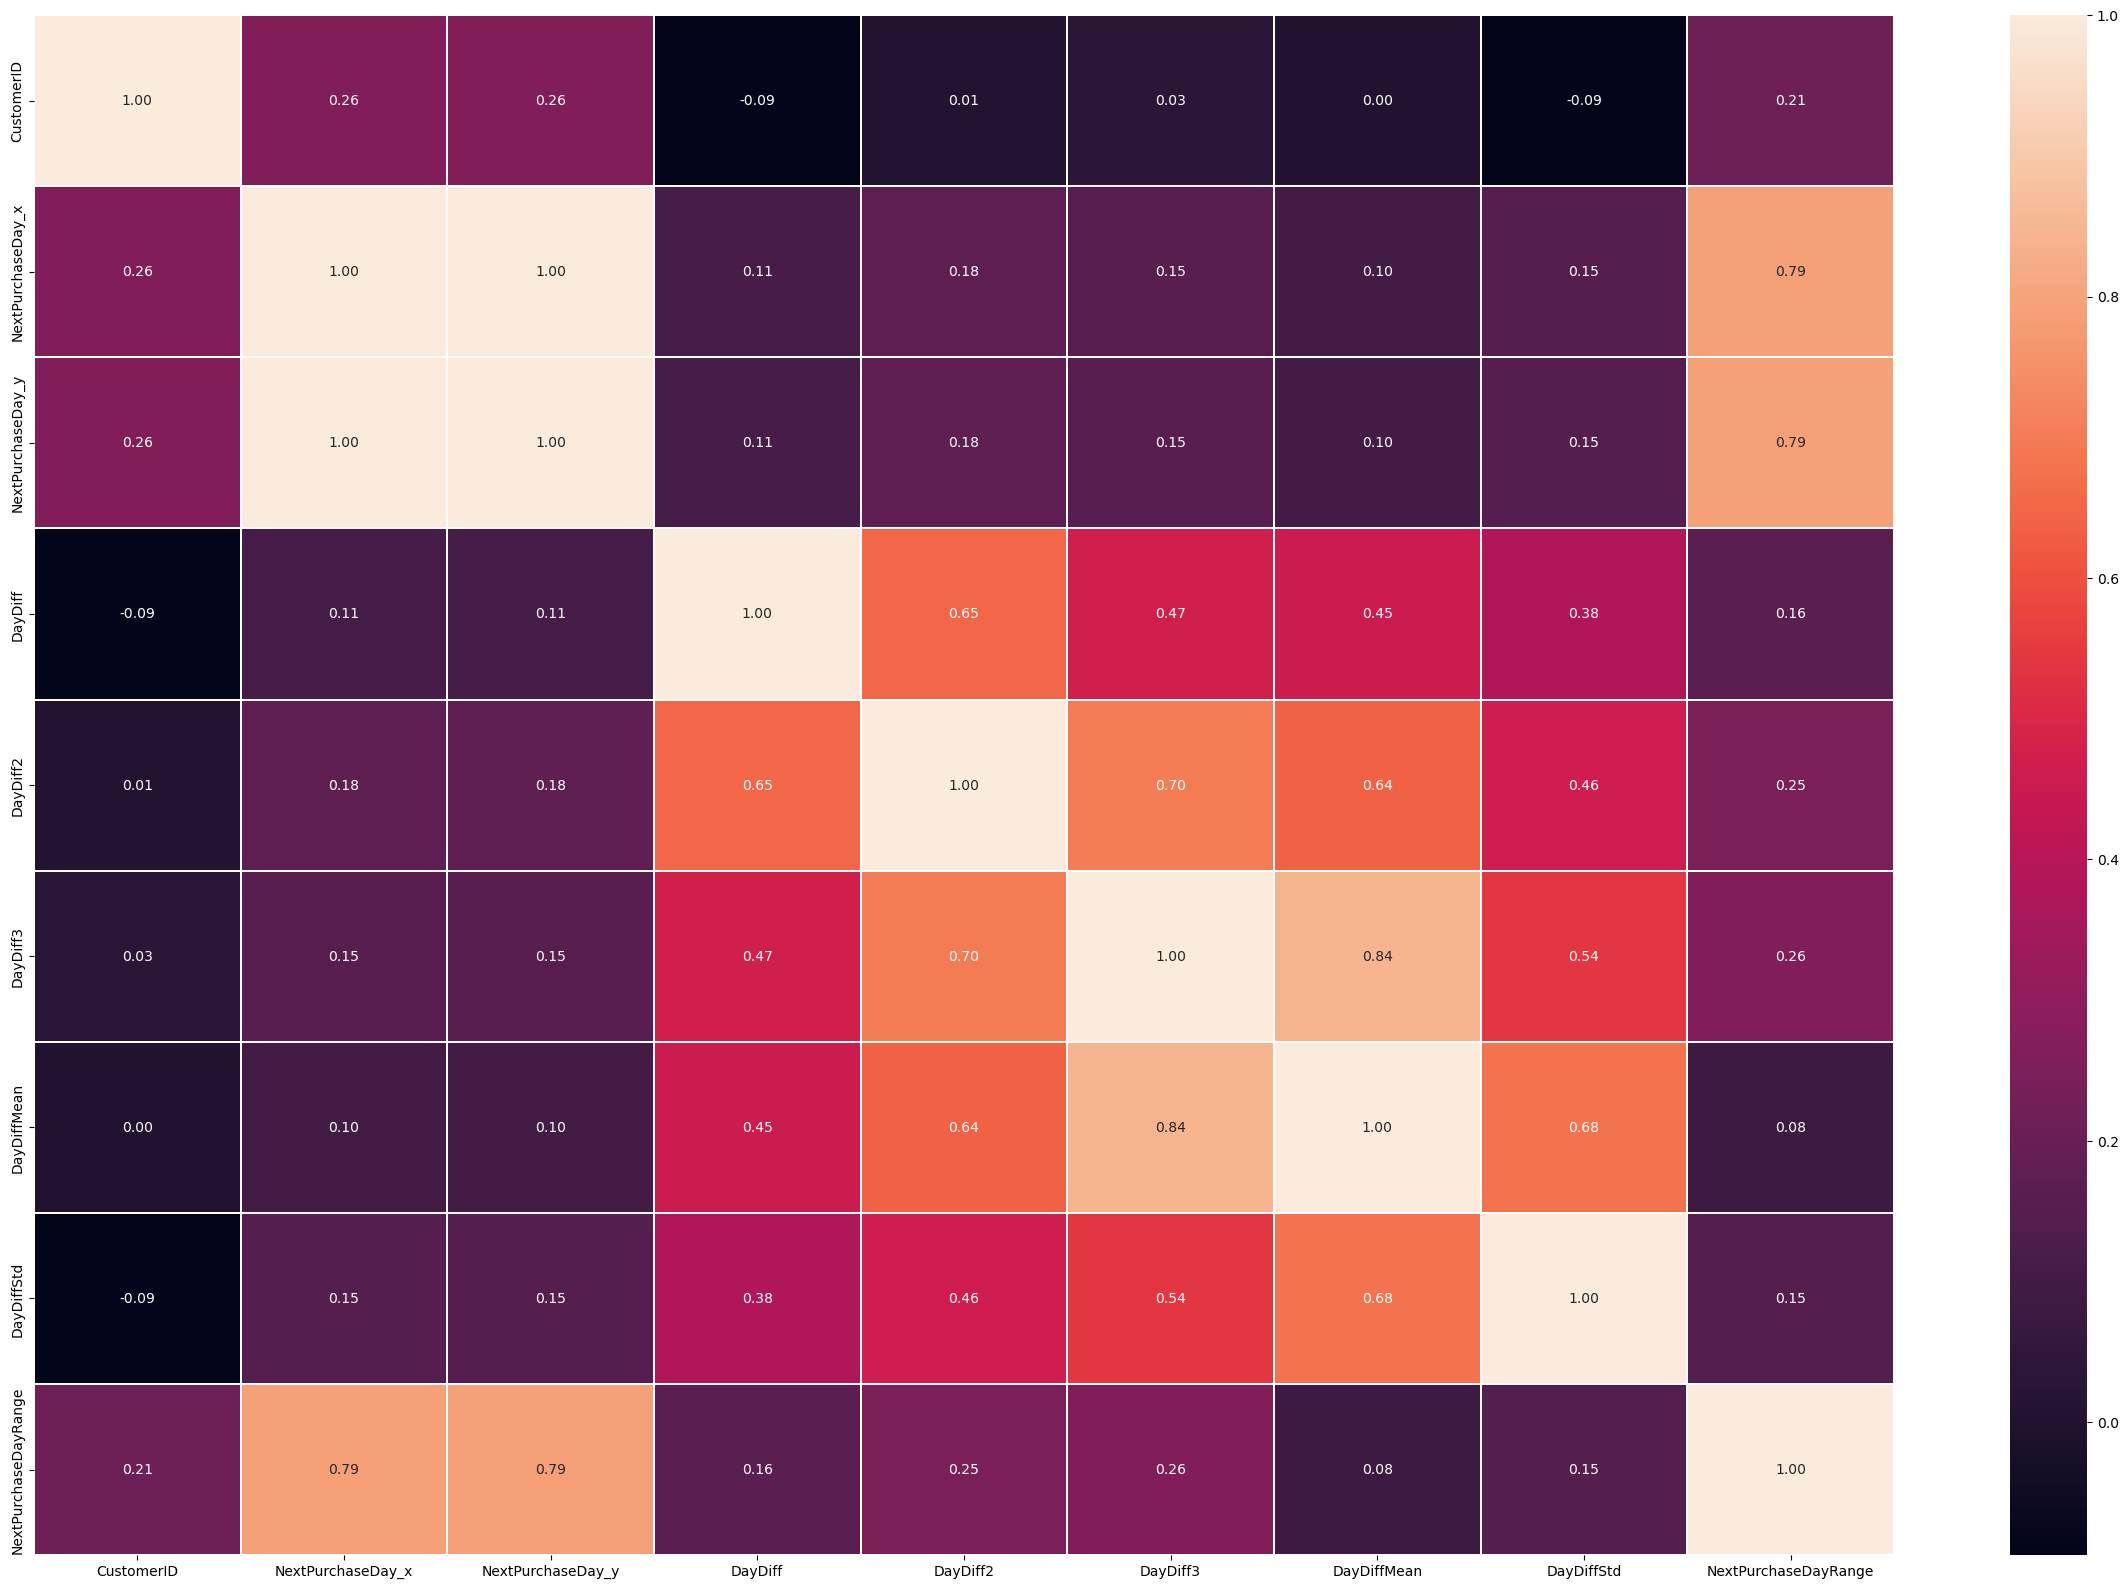

In [248]:
corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")
plt.show()

In [249]:
tx_class.columns

Index(['CustomerID', 'NextPurchaseDay_x', 'NextPurchaseDay_y', 'DayDiff',
       'DayDiff2', 'DayDiff3', 'DayDiffMean', 'DayDiffStd',
       'NextPurchaseDayRange'],
      dtype='object')

In [251]:
#splitting 
tx_class = tx_class.drop(['NextPurchaseDay_x','NextPurchaseDay_y'],axis=1)
X = tx_class.drop(columns = ['NextPurchaseDayRange'])
y = tx_class["NextPurchaseDayRange"]

In [252]:
#Encoder for y variable
enc =LabelEncoder()
y = enc.fit_transform(y)

In [253]:
y

array([3, 0, 0, 3, 1, 3, 2, 1, 0, 3, 2, 0, 3, 3, 0, 1, 3, 0, 3, 3, 1, 1,
       1, 1, 3, 3, 3, 3, 2, 3, 0, 1, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3,
       3, 3, 0, 3, 1, 3, 3, 1, 2, 2, 2], dtype=int64)

In [254]:
X

,CustomerID,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,15100,16.0,72.0,153.0,39.250000,35.621857
1,15311,8.0,19.0,35.0,14.100000,7.809538
2,16029,42.0,48.0,77.0,25.666667,18.230012
3,17511,4.0,5.0,50.0,21.500000,31.778924
4,13408,18.0,59.0,67.0,23.500000,14.011900
5,13767,26.0,56.0,76.0,28.000000,6.733003
6,13694,37.0,49.0,65.0,16.500000,15.066519
7,14911,1.0,22.0,28.0,12.000000,14.142136
8,17841,12.0,37.0,53.0,20.000000,14.947527
9,13093,5.0,29.0,76.0,25.333333,21.031722


In [255]:
# Checking balancing of data
tx_class.NextPurchaseDayRange.value_counts()

4.0    28
2.0    11
1.0     8
3.0     8
Name: NextPurchaseDayRange, dtype: int64

In [256]:
#balancing the data
sm= SMOTE()
resampled_X, resampled_y = sm.fit_resample(X, y)

In [259]:
X.shape


(55, 6)

In [260]:
y.shape

(55,)

In [261]:
resampled_X.shape

(112, 6)

In [262]:
resampled_y.shape

(112,)

In [295]:
X_train, X_test, y_train, y_test = train_test_split(resampled_X, resampled_y, test_size=0.2,random_state=44)

In [296]:
#create an array of models
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))


In [297]:
# Measure the accuracy 
from sklearn.model_selection import KFold, cross_val_score

for name,model in models:
    kfold = KFold(n_splits=2)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

C:\Users\Deepika\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Deepika\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

LR [0.26666667 0.34090909]
NB [0.57777778 0.38636364]
RF [0.44444444 0.47727273]
SVC [0.2        0.15909091]
Dtree [0.4 0.5]
XGB [0.44444444 0.45454545]
KNN [0.31111111 0.38636364]


C:\Users\Deepika\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Deepika\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

# MULTI-CLASSIFICATION MODEL

In [298]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.65


In [308]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(1,12,1),
 'min_child_weight':range(1,8,1)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 6, 'min_child_weight': 1}, 0.5161616161616162)

In [309]:
xgb_model = xgb.XGBClassifier(max_depth = 6, min_child_weight= 4).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.99
Accuracy of XGB classifier on test set: 0.65


# 7. Perform cohort analysis by defining below cohorts

In [456]:
def get_month(x) : return dt.datetime(x.year,x.month,1)
df['InvoiceMonth'] = df['Transaction_Date'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')
df.tail()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,Month,Coupon_Code,Discount_pct,Revenue,InvoiceMonth,CohortMonth
52519,14044,47224,2019-12-17,GGOEGGCX056199,Gift Card- $100.00,Gift Cards,1,101.93,0.0,Clicked,M,California,49,0.05,Dec,GC30,30,71.98,2019-12-01,2019-12-01
52520,15311,47511,2019-12-19,GGOEGGCX056299,Gift Card - $25.00,Gift Cards,2,25.48,0.0,Used,F,Chicago,40,0.05,Dec,GC30,30,21.01,2019-12-01,2019-01-01
52521,12842,47997,2019-12-23,GGOEGGCX056399,Gift Card - $250.00,Gift Cards,1,254.82,0.0,Used,F,New Jersey,27,0.05,Dec,GC30,30,224.87,2019-12-01,2019-12-01
52522,14462,48062,2019-12-25,GGOEGGCX056299,Gift Card - $25.00,Gift Cards,1,25.48,0.0,Not Used,F,Chicago,42,0.05,Dec,GC30,30,-4.47,2019-12-01,2019-07-01
52523,15808,48367,2019-12-29,GGOEGGCX056199,Gift Card- $100.00,Gift Cards,1,101.93,0.0,Clicked,F,California,6,0.05,Dec,GC30,30,71.98,2019-12-01,2019-02-01


In [458]:
def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day 

invoice_year,invoice_month,_ = get_month_int(df,'InvoiceMonth')
cohort_year,cohort_month,_ = get_month_int(df,'CohortMonth')

year_diff = invoice_year - cohort_year 
month_diff = invoice_month - cohort_month 

df['CohortIndex'] = year_diff * 12 + month_diff + 1 

In [459]:
#Count monthly active customers from each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2019-01-01,215.0,13.0,24.0,34.0,23.0,44.0,35.0,47.0,23.0,28.0,20.0,34.0
2019-02-01,96.0,7.0,9.0,16.0,17.0,22.0,19.0,15.0,12.0,11.0,16.0,NaN
2019-03-01,177.0,18.0,35.0,25.0,32.0,33.0,22.0,22.0,15.0,19.0,NaN,NaN
2019-04-01,163.0,14.0,24.0,24.0,18.0,15.0,10.0,16.0,12.0,NaN,NaN,NaN
2019-05-01,112.0,12.0,9.0,13.0,10.0,13.0,14.0,8.0,NaN,NaN,NaN,NaN
2019-06-01,137.0,20.0,22.0,12.0,11.0,14.0,11.0,NaN,NaN,NaN,NaN,NaN
2019-07-01,93.0,12.0,4.0,5.0,10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01,136.0,14.0,16.0,11.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,78.0,6.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# RETENTION TABLE

In [460]:
# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis 
retention.round(3) * 100 #to show the number as percentage 

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2019-01-01,100.0,6.0,11.2,15.8,10.7,20.5,16.3,21.9,10.7,13.0,9.3,15.8
2019-02-01,100.0,7.3,9.4,16.7,17.7,22.9,19.8,15.6,12.5,11.5,16.7,NaN
2019-03-01,100.0,10.2,19.8,14.1,18.1,18.6,12.4,12.4,8.5,10.7,NaN,NaN
2019-04-01,100.0,8.6,14.7,14.7,11.0,9.2,6.1,9.8,7.4,NaN,NaN,NaN
2019-05-01,100.0,10.7,8.0,11.6,8.9,11.6,12.5,7.1,NaN,NaN,NaN,NaN
2019-06-01,100.0,14.6,16.1,8.8,8.0,10.2,8.0,NaN,NaN,NaN,NaN,NaN
2019-07-01,100.0,12.9,4.3,5.4,10.8,8.6,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01,100.0,10.3,11.8,8.1,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,100.0,7.7,3.8,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


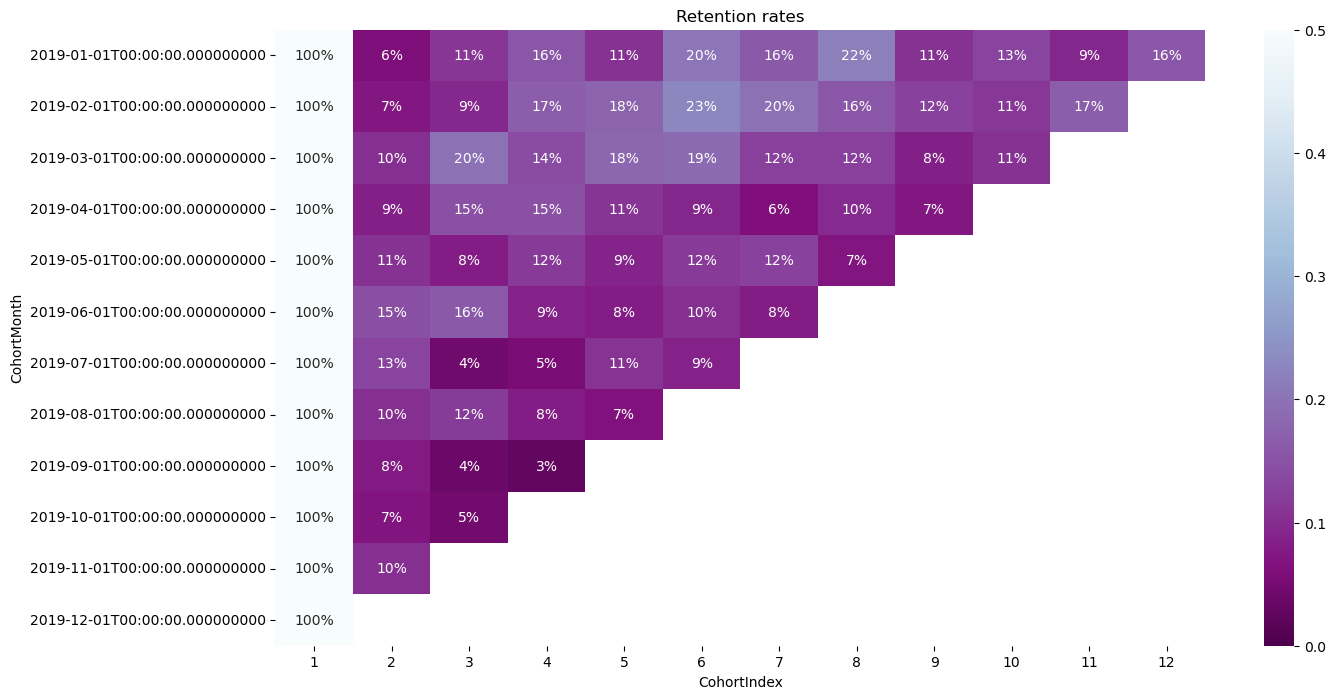

In [461]:
#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu_r")
plt.show()